# Environment

In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import sys

In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq[0])

    def render(self, cur_state=None):
        grid = np.zeros((self.num_rows, self.num_cols))

        for obs in self.obs_states:
            grid[obs[0], obs[1]] = 1
        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 4
        for bad in self.bad_states:
            grid[bad[0], bad[1]] = 2
        for restart in self.restart_states:
            grid[restart[0], restart[1]] = 3
        for start in self.start_state:
            grid[start[0], start[1]] = 5
        
        if cur_state is not None:
            grid[cur_state[0], cur_state[1]] = 6

        cmap = colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00']) 
        
        plt.pcolor(grid, edgecolors='k', linewidths=3, cmap=cmap)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [4]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [5]:
row_col_to_seq(np.array([[5, 2]]), 10)
seq_to_col_row(25, 10)

array([[2, 5]])

<Figure size 640x480 with 0 Axes>

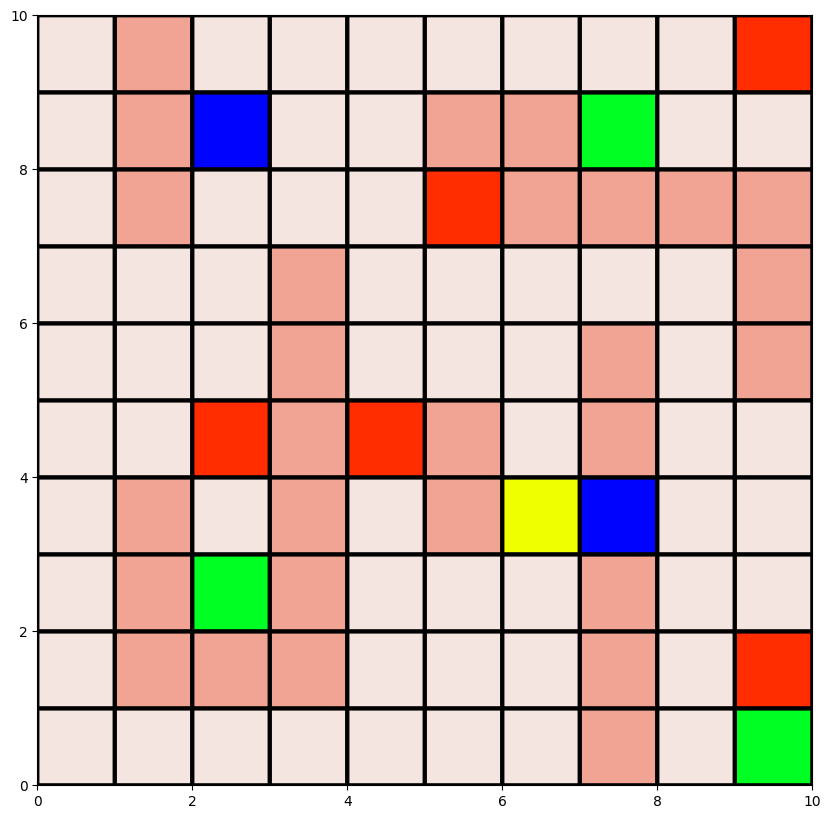

In [6]:
def plot(env):
    plt.clf()
    plt.figure(figsize=(num_rows,num_cols))
    env.render()
    plt.show()

plot(env)

# Starting conditions

In [7]:
start_states  = ((0, 4), (3, 6))
wind_states = ((False, 1.0), (False, 0.7), (True, 1.0))

init_states = [(x, y) for x in start_states for y in wind_states]


# Hyperparameters

In [8]:
from scipy.special import softmax
import random

seed = 42
rg = np.random.RandomState(seed)

def argmax_4(arr):
    best_val = arr[0]
    best_ind = 0
    cur_val = arr[1]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 1
    cur_val = arr[2]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 2
    cur_val = arr[3]
    if cur_val > best_val:
        best_val = cur_val
        best_ind = 3
    return best_ind

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    arr = Q[state[0], state[1]]
    rand_arm = random.getrandbits(2)
    best_arm = argmax_4(arr)
    index = (rg.random()<epsilon)
    return (best_arm, rand_arm)[index]

# Softmax
def choose_action_softmax(Q, state, tau=0, rg=rg):
    arr = Q[state[0], state[1]]
    exp = np.exp(arr/tau)
    probs = exp/np.sum(exp)
    return rg.choice(4, p=probs)

In [9]:
# choose_action_softmax(Q, (5, 5), tau=1, rg=rg)
# (Q[5, 5], 1)

In [10]:
tau = (0.1, 0.25, 0.75)
epsilon = (0.1, 0.2, 0.3)
policy = tuple((choose_action_epsilon, e) for e in epsilon)  + tuple((choose_action_softmax, t) for t in tau)
alpha = (0.1, 0.2, 0.4)
gamma = (0.7, 0.8, 0.9)

params = [(a, g, p) for a in alpha for g in gamma for p in policy]



# Sarsa

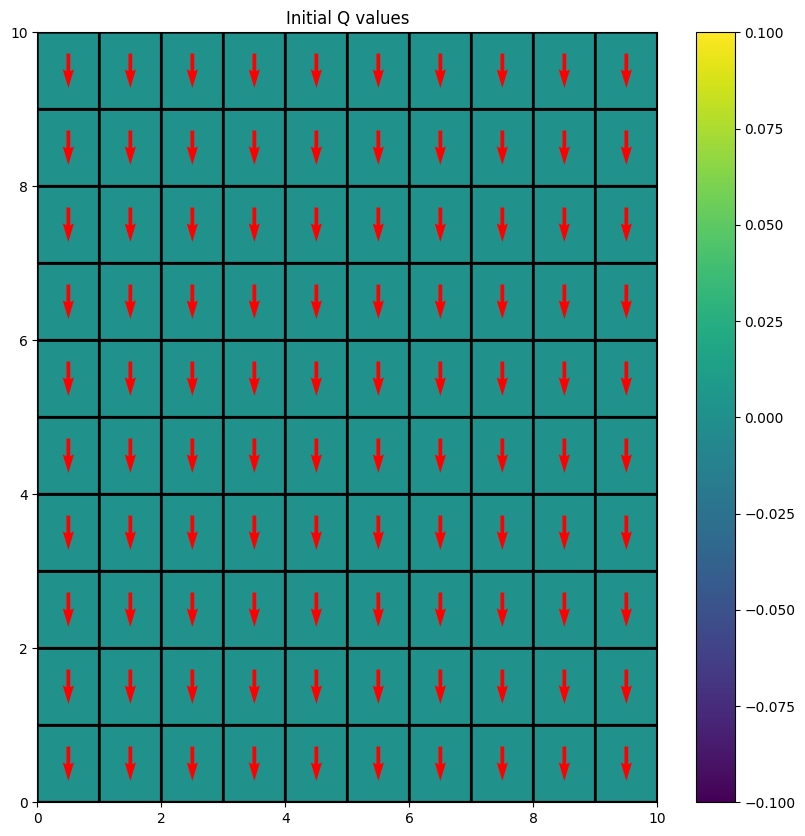

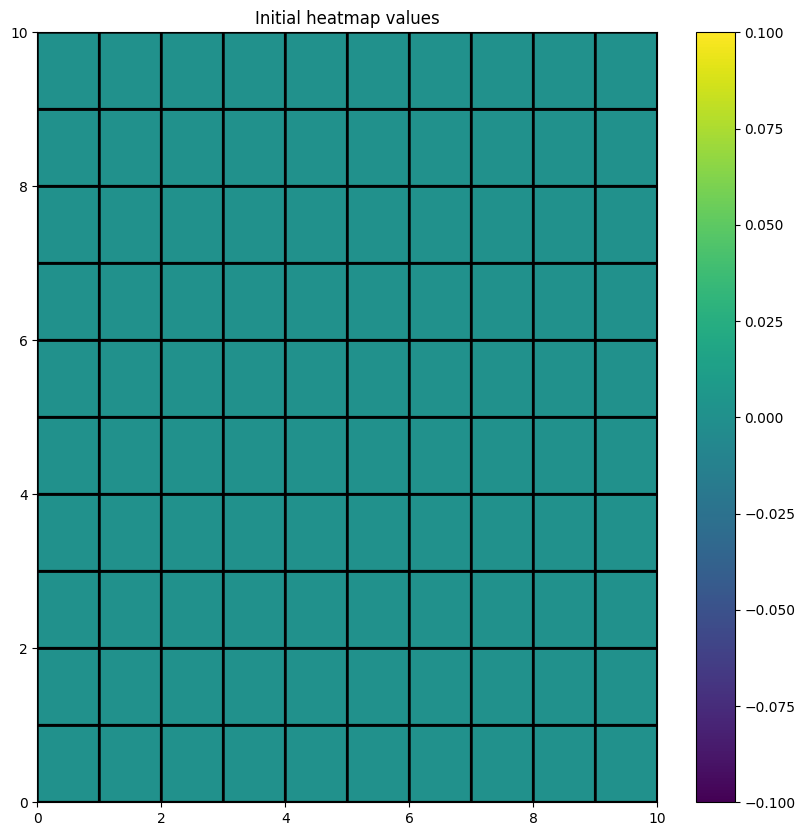

In [11]:
# Q values
Q = np.zeros((num_rows, num_cols, 4))
heatmap = np.zeros((num_rows, num_cols))
episodes = 5000

def plot_Q(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 1 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()


def plot_heatmap(Q, message = "Q plot"):
    
    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q, edgecolors='k', linewidths=2)
    plt.colorbar()
    # def x_direct(a):
    #     if a in [0, 1]:
    #         return 0
    #     return 1 if a == 3 else -1
    # def y_direct(a):
    #     if a in [3, 2]:
    #         return 0
    #     return 1 if a == 1 else -1
    # policy = Q
    # policyx = np.vectorize(x_direct)(policy)
    # policyy = np.vectorize(y_direct)(policy)
    # idx = np.indices(policy.shape)
    # plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()



def clear_output(wait=False):
    """Clear the output of the current cell receiving output.

    Parameters
    ----------
    wait : bool [default: false]
        Wait to clear the output until new output is available to replace it."""
    from IPython.core.interactiveshell import InteractiveShell
    if InteractiveShell.initialized():
        InteractiveShell.instance().display_pub.clear_output(wait)
    else:
        print('\033[2K\r', end='')
        sys.stdout.flush()
        print('\033[2K\r', end='')
        sys.stderr.flush()

plot_Q(Q, "Initial Q values")
plot_heatmap(heatmap, "Initial heatmap values")

In [12]:
# constants
def sarsa(Q, env, start_state, policy, alpha, gamma, episodes, plot=True):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    heatmap = np.zeros((num_rows, num_cols))

    for episode in tqdm(range(episodes)):
        state = env.reset()
        state_rc = seq_to_col_row(state, num_cols)[0]
        action = policy[0](Q, state_rc, policy[1])
        done = False
        rewards = 0
        steps = 0
        while not done and steps <= 100:
            heatmap[state_rc[0], state_rc[1]] += 1
            next_state, reward = env.step(state, action)
            done = (next_state in env.goal_states_seq)
            next_state_rc = seq_to_col_row(next_state, num_cols)[0]
            next_action = policy[0](Q, next_state_rc, policy[1])
            # print(action, next_action, next_state_rc, state_rc, alpha, gamma, reward)
            Q[state_rc[0], state_rc[1], action] += alpha * (reward[0] + gamma * Q[next_state_rc[0], next_state_rc[1], next_action] - Q[state_rc[0], state_rc[1], action])
            state = next_state
            state_rc = next_state_rc
            action = next_action
            rewards += reward[0]
            steps += 1
            # print(env.goal_states_seq)
        episode_rewards[episode] = rewards
        steps_to_completion[episode] = steps
        # print(steps)
        if episode % 100 == 0 and plot:
            clear_output(wait=True)
            plot_Q(Q, f"Q values for policy = {policy[0].__name__}, value = {policy[1]}: reward={episode_rewards[episode]}, steps={steps_to_completion[episode]}")

    return heatmap, episode_rewards, steps_to_completion

In [13]:
start, (wind, transition) = init_states[4]
    # print(start, wind, transition)
env.wind = wind
env.p_good_trans = transition
env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
env = env.create_gridworld()
    # print(env.goal_states_se)

Q = np.zeros((num_rows, num_cols, 4))
episodes = 10000   

    # for a, g, (p, val) in params:
    #     print(a, g, p, val)
    #     sarsa(Q, env, start, (p, val), a, g, episodes)
    #     plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}")
# sarsa(Q, env, start, (choose_action_softmax, 0.5), 0.5, 0.9, episodes, plot=False)

In [14]:
from time import sleep

state = env.reset()
done = False
steps = 0
tot_reward = 0
while False:
    clear_output(wait=True)
    # print(state)
    state_rc = seq_to_col_row(state, num_cols)[0]
    state, reward= env.step(state, Q[state_rc[0], state_rc[1]].argmax())
    print(state, Q[state_rc[0], state_rc[1]].argmax())
    done = (state in env.goal_states_seq)
    plt.figure(figsize=(10, 10))
    env.render(cur_state=state_rc)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

Steps: 0, Total Reward: 0


In [15]:

def show_rewards_steps(steps_avgs, reward_avgs):
    steps_avgs = np.array(steps_avgs)
    reward_avgs = np.array(reward_avgs)

    # Calculate mean and standard deviation
    steps_mean = np.mean(steps_avgs, axis=0)
    steps_std = np.std(steps_mean, axis=0)
    reward_mean = np.mean(reward_avgs, axis=0)
    reward_std = np.std(reward_mean)

    # Plotting rewards
    plt.figure()
    plt.plot(reward_mean, label='Mean Reward')
    plt.fill_between(range(len(reward_mean)), reward_mean - reward_std, reward_mean + reward_std, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.show()

    # Plotting steps
    plt.figure()
    plt.plot(steps_mean, label='Mean Steps to Goal')
    plt.fill_between(range(len(steps_mean)), steps_mean - steps_std, steps_mean + steps_std, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Number of steps to Goal')
    plt.legend()
    plt.show()

# Example usage:
# Assuming steps_avgs and reward_avgs are lists containing data for each run
# show_rewards_steps(steps_avgs, reward_avgs)


(0, 4) False 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


 10%|▉         | 490/5000 [00:00<00:07, 580.58it/s]

100%|██████████| 5000/5000 [00:07<00:00, 703.24it/s]


Best reward:-100.8886
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 702.27it/s]


Best reward:-100.8222
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 723.20it/s]


Best reward:-101.2008
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:15<00:00, 317.23it/s]


Best reward:-45.6984
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:22<00:00, 224.30it/s]


Best reward:-75.1138
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 204.29it/s]


Best reward:-84.8606
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 3286.17it/s]


Best reward:-11.0936
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:01<00:00, 3044.85it/s]


Best reward:-14.6918
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 2053.28it/s]


Best reward:-21.5664
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 888.89it/s] 


Best reward:-9.8208
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 676.13it/s]


Best reward:-16.6568
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:18<00:00, 274.76it/s]


Best reward:-59.0674
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 3116.29it/s]


Best reward:-10.3796
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:01<00:00, 3016.58it/s]


Best reward:-13.6256
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:01<00:00, 2636.89it/s]


Best reward:-17.0418
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1141.30it/s]


Best reward:-8.4204
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1136.36it/s]


Best reward:-8.7754
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:07<00:00, 665.01it/s]


Best reward:-15.075
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 724.66it/s]


Best reward:-101.0206
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 749.98it/s]


Best reward:-101.2112
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 713.13it/s]


Best reward:-101.177
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:15<00:00, 321.49it/s]


Best reward:-44.512
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:19<00:00, 258.52it/s]


Best reward:-65.467
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 211.65it/s]


Best reward:-83.5384
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 2854.27it/s]


Best reward:-11.0576
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 2361.77it/s]


Best reward:-16.4306
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 815.47it/s] 


Best reward:-87.5764
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 746.43it/s]


Best reward:-9.3378
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 696.03it/s]


Best reward:-14.678
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:16<00:00, 295.47it/s]


Best reward:-56.3162
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 3711.21it/s]


Best reward:-9.8792
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:01<00:00, 3442.47it/s]


Best reward:-13.14
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:01<00:00, 2663.12it/s]


Best reward:-17.5022
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1393.69it/s]


Best reward:-7.284
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1244.71it/s]


Best reward:-7.6626
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:06<00:00, 757.51it/s]


Best reward:-13.8218
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 764.87it/s]


Best reward:-101.0514
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 787.67it/s]


Best reward:-101.037
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 753.21it/s]


Best reward:-101.0814
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:15<00:00, 320.10it/s]


Best reward:-43.792
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:21<00:00, 235.55it/s]


Best reward:-73.2112
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 216.20it/s]


Best reward:-84.6764
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1480.73it/s]


Best reward:-43.1474
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 786.33it/s]


Best reward:-97.7206
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 759.39it/s]


Best reward:-100.6412
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 794.44it/s]


Best reward:-8.544
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 761.32it/s]


Best reward:-14.9362
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:17<00:00, 294.11it/s]


Best reward:-55.232
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 3320.91it/s]


Best reward:-11.1356
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:01<00:00, 2774.60it/s]


Best reward:-15.1988
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 2163.04it/s]


Best reward:-20.4802
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 873.37it/s] 


Best reward:-6.8122
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1179.04it/s]


Best reward:-7.0906
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:06<00:00, 794.25it/s]


Best reward:-12.969
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:05<00:00, 850.38it/s]


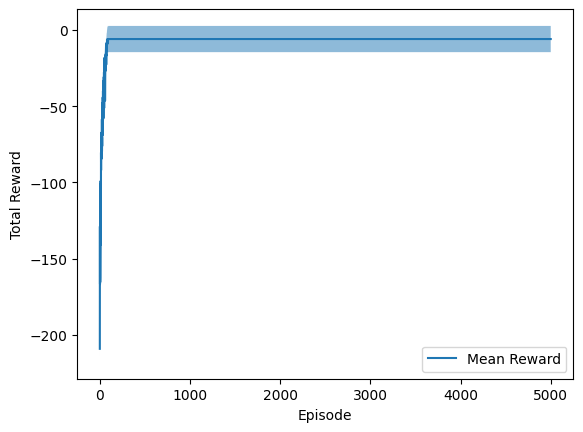

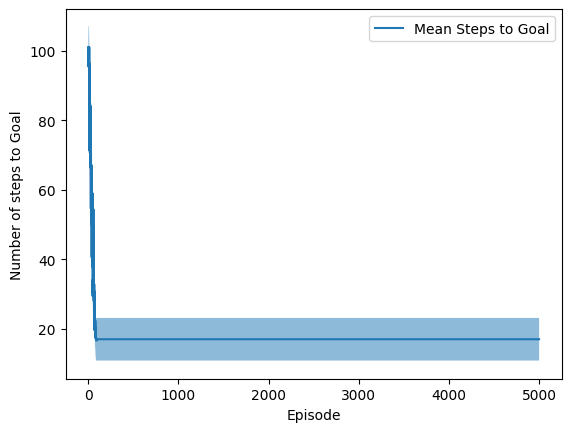

100%|██████████| 5000/5000 [00:05<00:00, 868.37it/s]


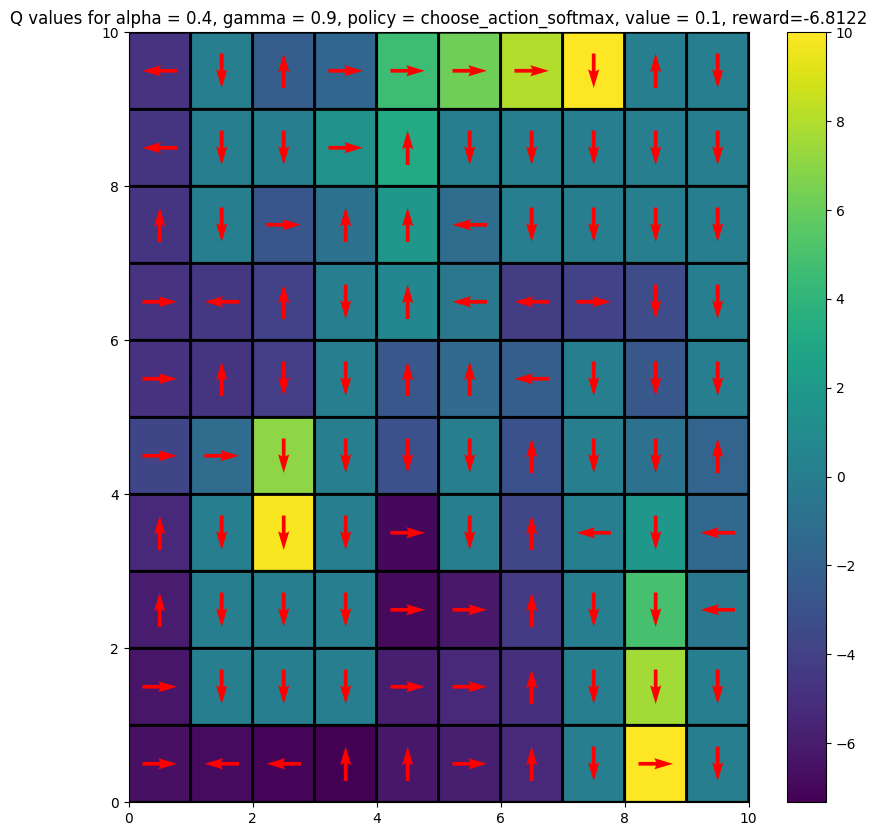

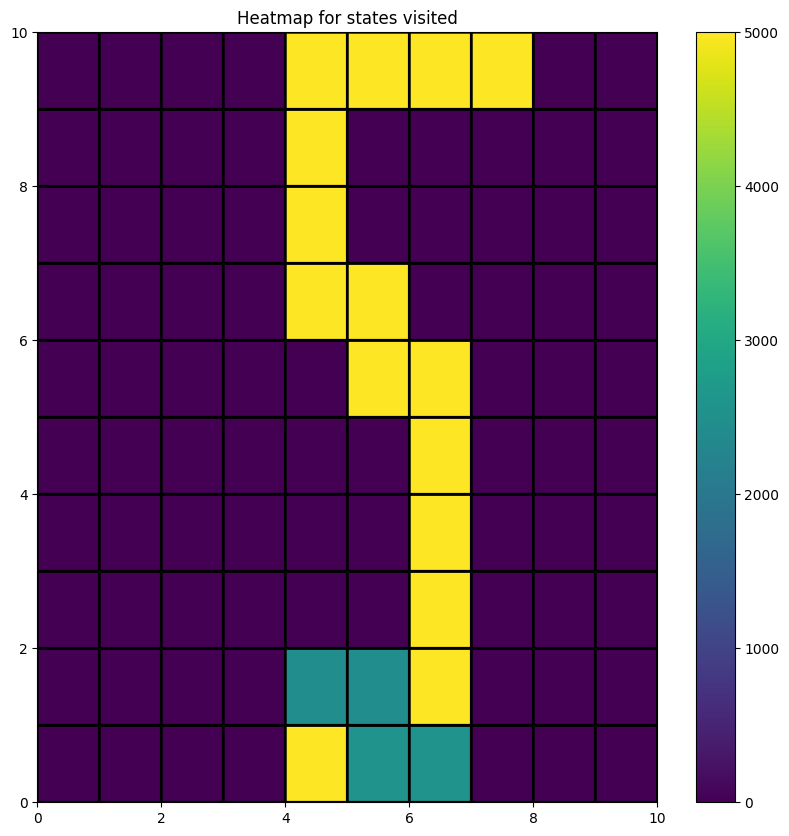

(0, 4) False 0.7
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 763.45it/s]


Best reward:-101.4678
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 753.83it/s]


Best reward:-101.429
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 752.09it/s]


Best reward:-101.3852
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:25<00:00, 192.79it/s]


Best reward:-94.5558
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:26<00:00, 188.37it/s]


Best reward:-95.6826
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:27<00:00, 184.36it/s]


Best reward:-96.8252
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 739.82it/s]


Best reward:-100.4728
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 712.29it/s]


Best reward:-101.312
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 727.10it/s]


Best reward:-100.9432
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:21<00:00, 232.25it/s]


Best reward:-74.685
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:23<00:00, 210.14it/s]


Best reward:-84.3868
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 198.78it/s]


Best reward:-92.9282
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2147.90it/s]


Best reward:-22.7832
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1849.70it/s]


Best reward:-27.9768
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1482.35it/s]


Best reward:-35.5764
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 762.73it/s] 


Best reward:-19.837
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:08<00:00, 573.04it/s]


Best reward:-28.0152
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 261.07it/s]


Best reward:-67.8274
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 753.23it/s]


Best reward:-101.2198
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 762.80it/s]


Best reward:-101.3744
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 742.89it/s]


Best reward:-101.5938
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:25<00:00, 195.51it/s]


Best reward:-94.6398
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:26<00:00, 190.33it/s]


Best reward:-96.5748
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 192.85it/s]


Best reward:-97.1276
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 751.68it/s]


Best reward:-101.2394
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 735.79it/s]


Best reward:-101.2484
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 738.20it/s]


Best reward:-101.231
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:21<00:00, 232.76it/s]


Best reward:-74.1092
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:23<00:00, 208.54it/s]


Best reward:-84.9896
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 199.94it/s]


Best reward:-91.241
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2057.06it/s]


Best reward:-22.7278
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1629.10it/s]


Best reward:-29.6932
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1306.43it/s]


Best reward:-37.4366
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 788.95it/s] 


Best reward:-18.1454
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 660.11it/s]


Best reward:-23.123
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 254.35it/s]


Best reward:-67.3964
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 750.21it/s]


Best reward:-101.2852
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 726.04it/s]


Best reward:-101.4388
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 736.88it/s]


Best reward:-101.6662
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:26<00:00, 192.22it/s]


Best reward:-93.2956
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:26<00:00, 191.04it/s]


Best reward:-95.4434
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:26<00:00, 187.49it/s]


Best reward:-98.1254
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 740.71it/s]


Best reward:-100.5464
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 738.14it/s]


Best reward:-101.0468
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 725.57it/s]


Best reward:-101.4014
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:23<00:00, 217.10it/s]


Best reward:-80.843
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:25<00:00, 195.91it/s]


Best reward:-91.118
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 201.27it/s]


Best reward:-91.8302
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 878.87it/s] 


Best reward:-81.7896
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 801.60it/s] 


Best reward:-88.0182
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 770.83it/s] 


Best reward:-85.6918
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 777.13it/s]


Best reward:-18.8362
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:09<00:00, 553.49it/s]


Best reward:-27.1764
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 259.36it/s]


Best reward:-67.343
(0.2, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:06<00:00, 735.03it/s]


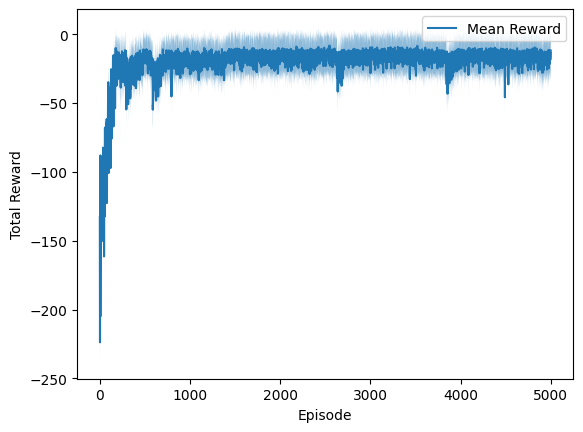

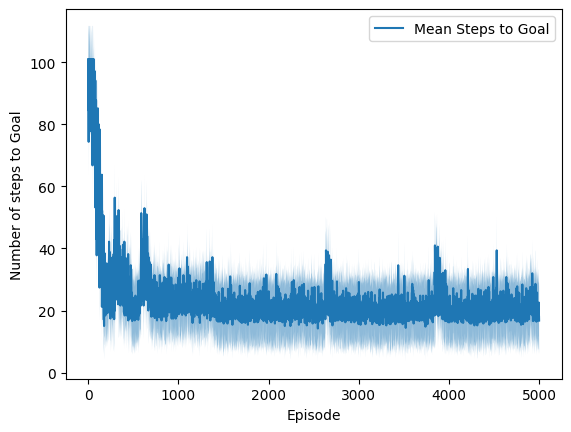

100%|██████████| 5000/5000 [00:06<00:00, 808.93it/s]


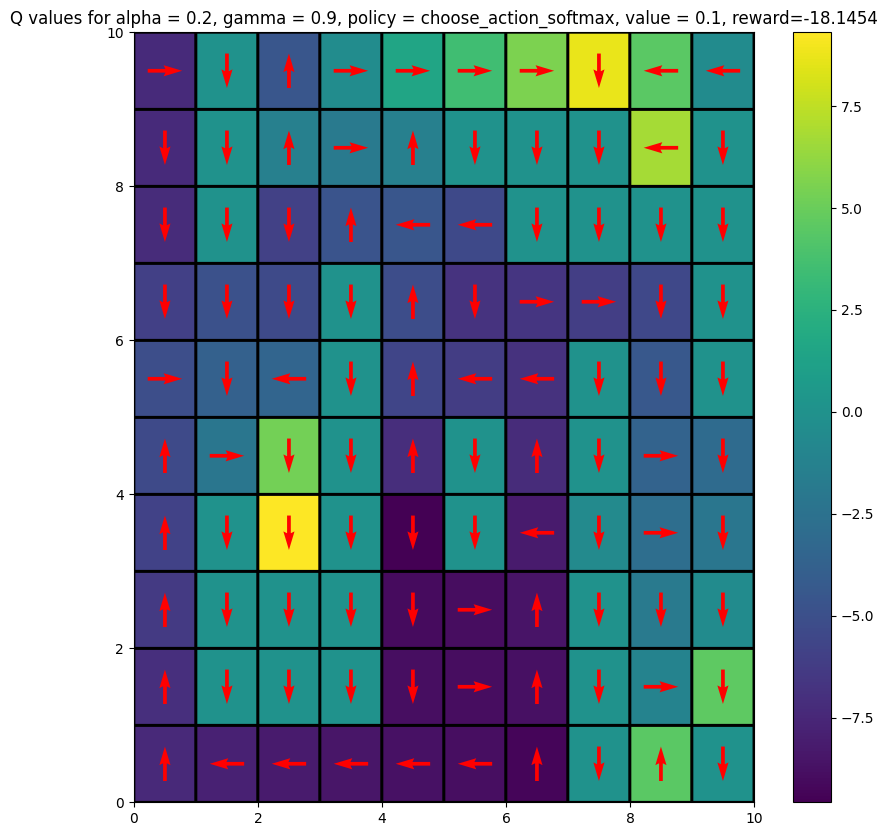

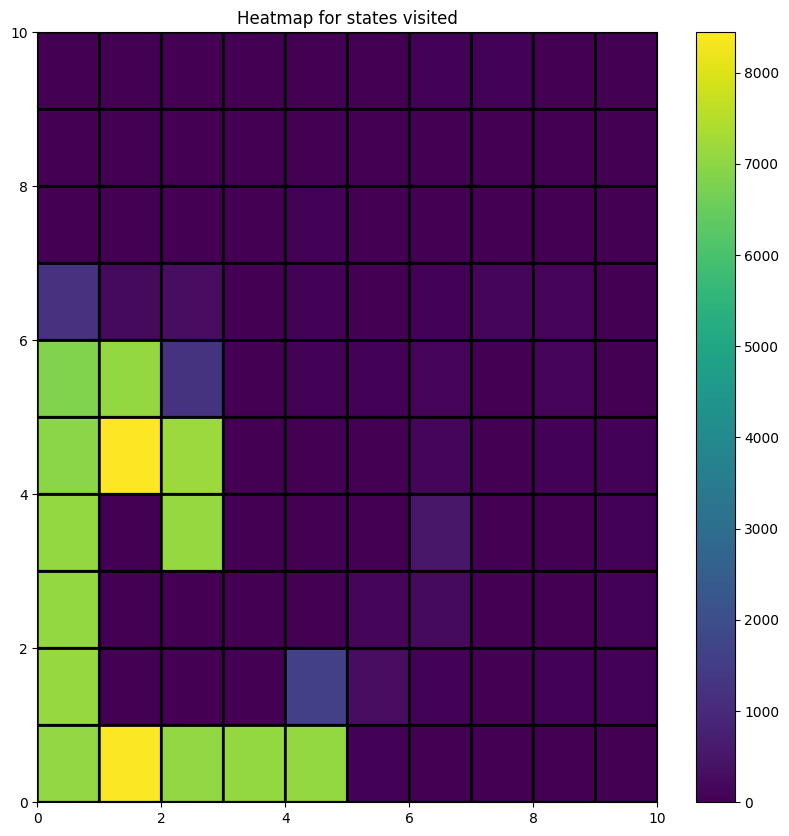

(0, 4) True 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1807.21it/s]


Best reward:-18.8634
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 591.33it/s]


Best reward:-91.4632
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 522.47it/s]


Best reward:-99.5566
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:29<00:00, 167.45it/s]


Best reward:-99.9958
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 163.61it/s]


Best reward:-100.7636
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:30<00:00, 162.93it/s]


Best reward:-101.0572
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2300.34it/s]


Best reward:-13.8048
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1876.48it/s]


Best reward:-18.5886
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1395.55it/s]


Best reward:-27.4302
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 692.90it/s]


Best reward:-17.9342
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:28<00:00, 177.78it/s]


Best reward:-91.9368
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:30<00:00, 163.19it/s]


Best reward:-100.5092
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2440.39it/s]


Best reward:-13.2174
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1750.88it/s]


Best reward:-17.9758
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 1674.54it/s]


Best reward:-24.7678
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 972.01it/s] 


Best reward:-10.2034
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 904.50it/s] 


Best reward:-10.8036
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 250.68it/s]


Best reward:-61.0298
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 705.59it/s] 


Best reward:-75.5464
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:09<00:00, 513.67it/s]


Best reward:-98.7952
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 507.25it/s]


Best reward:-100.0936
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:30<00:00, 164.63it/s]


Best reward:-100.4842
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 162.40it/s]


Best reward:-100.8238
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:30<00:00, 163.65it/s]


Best reward:-101.0212
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2236.91it/s]


Best reward:-13.5788
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1864.33it/s]


Best reward:-19.086
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1431.07it/s]


Best reward:-28.7182
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 738.45it/s]


Best reward:-15.363
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:27<00:00, 183.52it/s]


Best reward:-91.0418
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:30<00:00, 163.40it/s]


Best reward:-100.7456
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2487.40it/s]


Best reward:-12.6344
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1916.43it/s]


Best reward:-17.4378
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1604.05it/s]


Best reward:-24.6136
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1054.39it/s]


Best reward:-9.192
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1042.32it/s]


Best reward:-9.6256
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:18<00:00, 277.56it/s]


Best reward:-56.145
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 577.38it/s]


Best reward:-96.4564
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:09<00:00, 541.31it/s]


Best reward:-100.7378
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 518.74it/s]


Best reward:-101.407
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:30<00:00, 163.84it/s]


Best reward:-100.726
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 163.87it/s]


Best reward:-100.8502
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:29<00:00, 167.79it/s]


Best reward:-101.0276
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2041.33it/s]


Best reward:-15.1756
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1468.08it/s]


Best reward:-25.6814
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 719.09it/s] 


Best reward:-64.6884
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 502.53it/s]


Best reward:-26.197
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:29<00:00, 170.31it/s]


Best reward:-95.0894
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:30<00:00, 162.94it/s]


Best reward:-100.7076
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2183.69it/s]


Best reward:-13.4906
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1788.13it/s]


Best reward:-19.5354
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1467.76it/s]


Best reward:-27.88
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1049.73it/s]


Best reward:-8.868
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 965.60it/s] 


Best reward:-10.2944
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:17<00:00, 288.85it/s]


Best reward:-52.3406
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:05<00:00, 975.60it/s] 


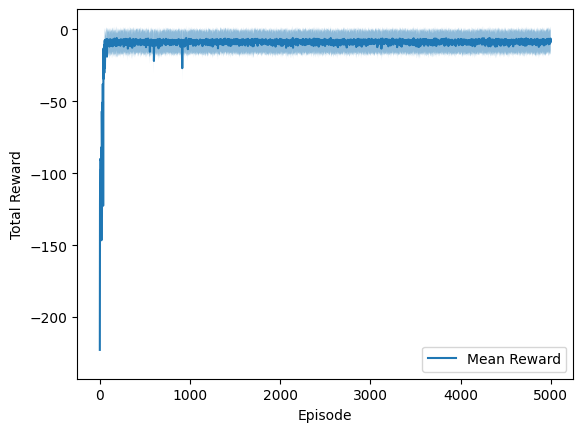

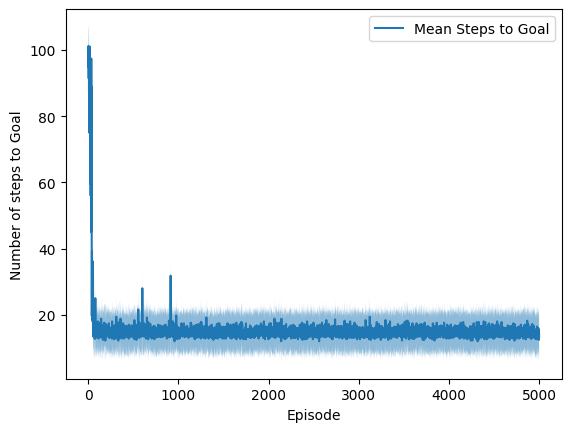

100%|██████████| 5000/5000 [00:04<00:00, 1016.91it/s]


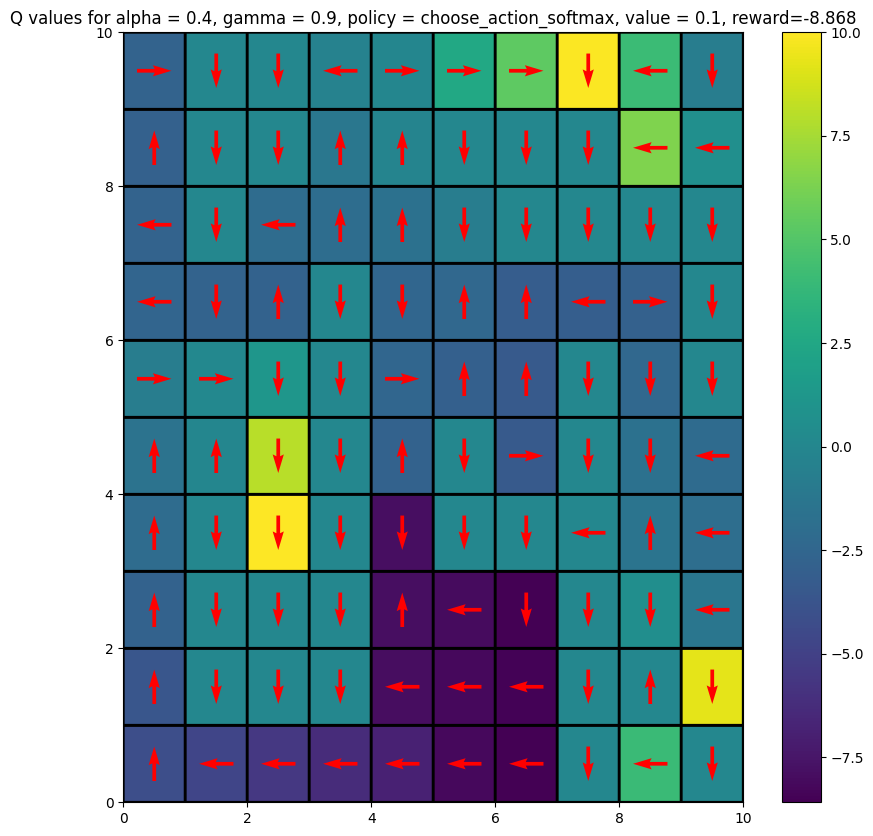

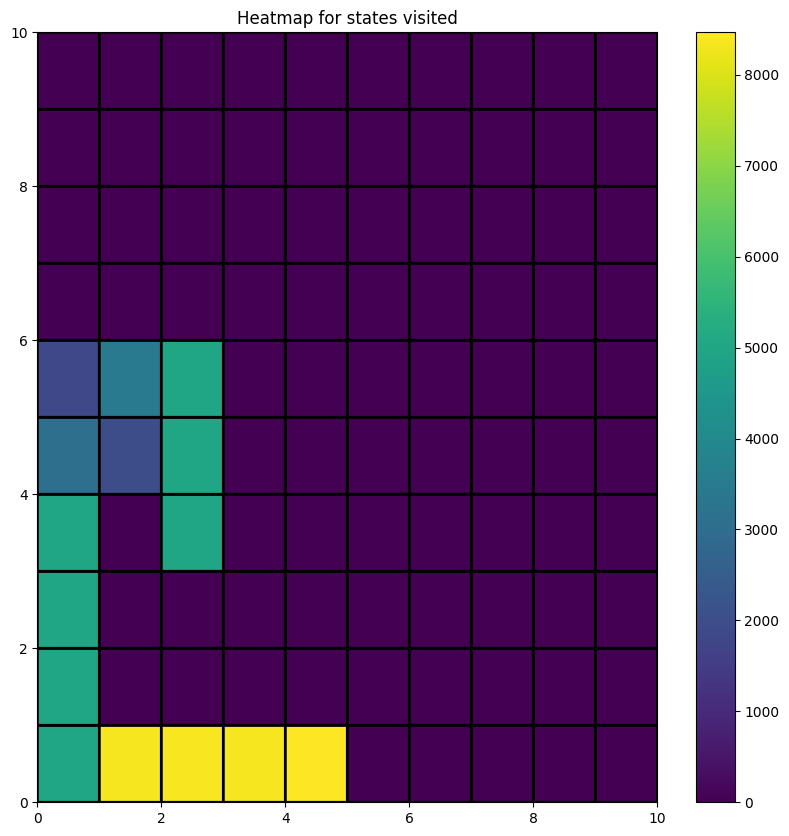

(3, 6) False 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1973.28it/s]


Best reward:-18.2548
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1079.84it/s]


Best reward:-60.7208
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 630.28it/s] 


Best reward:-81.1848
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 804.74it/s] 


Best reward:-7.859
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:12<00:00, 411.40it/s]


Best reward:-31.481
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 256.15it/s]


Best reward:-61.5144
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1890.48it/s]


Best reward:-10.0164
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 2067.64it/s]


Best reward:-20.4286
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1650.27it/s]


Best reward:-32.1788
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 990.58it/s] 


Best reward:-3.4376
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 873.49it/s] 


Best reward:-5.4396
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:11<00:00, 433.63it/s]


Best reward:-28.6434
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1942.80it/s]


Best reward:-8.3714
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1952.61it/s]


Best reward:-15.487
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 1840.35it/s]


Best reward:-26.0934
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 996.96it/s] 


Best reward:-3.109
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1029.18it/s]


Best reward:-3.5388
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:06<00:00, 813.60it/s] 


Best reward:-5.8286
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 844.35it/s] 


Best reward:-79.6054
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 789.16it/s] 


Best reward:-80.36
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 540.61it/s]


Best reward:-100.6308
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 834.82it/s] 


Best reward:-6.6224
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:11<00:00, 432.25it/s]


Best reward:-29.847
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:20<00:00, 249.33it/s]


Best reward:-62.6904
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2109.15it/s]


Best reward:-13.4602
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1798.65it/s]


Best reward:-22.0084
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 820.64it/s] 


Best reward:-74.0484
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1017.76it/s]


Best reward:-2.4126
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 953.03it/s] 


Best reward:-4.0626
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:11<00:00, 449.30it/s]


Best reward:-26.4714
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2160.66it/s]


Best reward:-7.6716
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1956.45it/s]


Best reward:-16.1292
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1630.42it/s]


Best reward:-27.5312
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1066.62it/s]


Best reward:-2.1446
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1063.62it/s]


Best reward:-2.2638
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:05<00:00, 893.45it/s] 


Best reward:-4.674
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 608.94it/s]


Best reward:-90.009
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:09<00:00, 540.70it/s]


Best reward:-101.3708
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 592.10it/s]


Best reward:-103.1026
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 918.37it/s] 


Best reward:-5.6472
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:11<00:00, 426.13it/s]


Best reward:-30.1396
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 257.74it/s]


Best reward:-61.0184
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1898.85it/s]


Best reward:-15.3664
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:05<00:00, 838.73it/s] 


Best reward:-60.3746
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 529.82it/s]


Best reward:-102.3286
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1024.94it/s]


Best reward:-1.78
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 981.88it/s] 


Best reward:-3.2036
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:10<00:00, 456.29it/s]


Best reward:-25.2458
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2083.73it/s]


Best reward:-10.8374
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1646.63it/s]


Best reward:-23.6202
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1204.21it/s]


Best reward:-43.3304
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1036.68it/s]


Best reward:-1.6384
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1066.91it/s]


Best reward:-1.8588
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:05<00:00, 936.84it/s] 


Best reward:-3.773
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:04<00:00, 1247.81it/s]


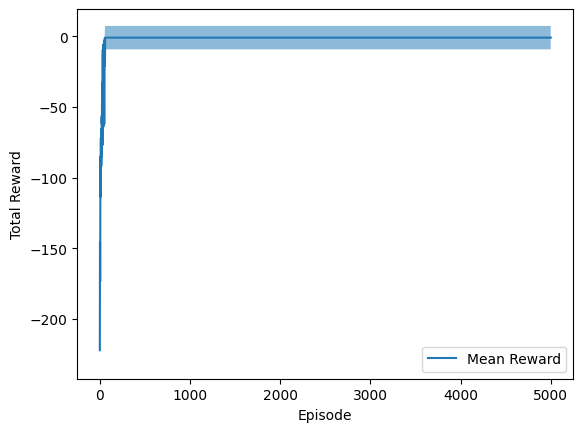

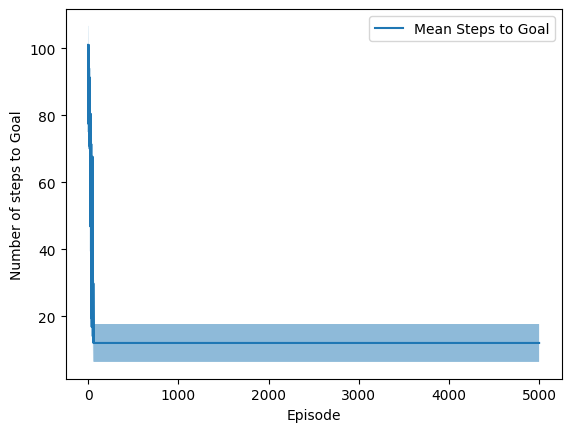

100%|██████████| 5000/5000 [00:04<00:00, 1244.88it/s]


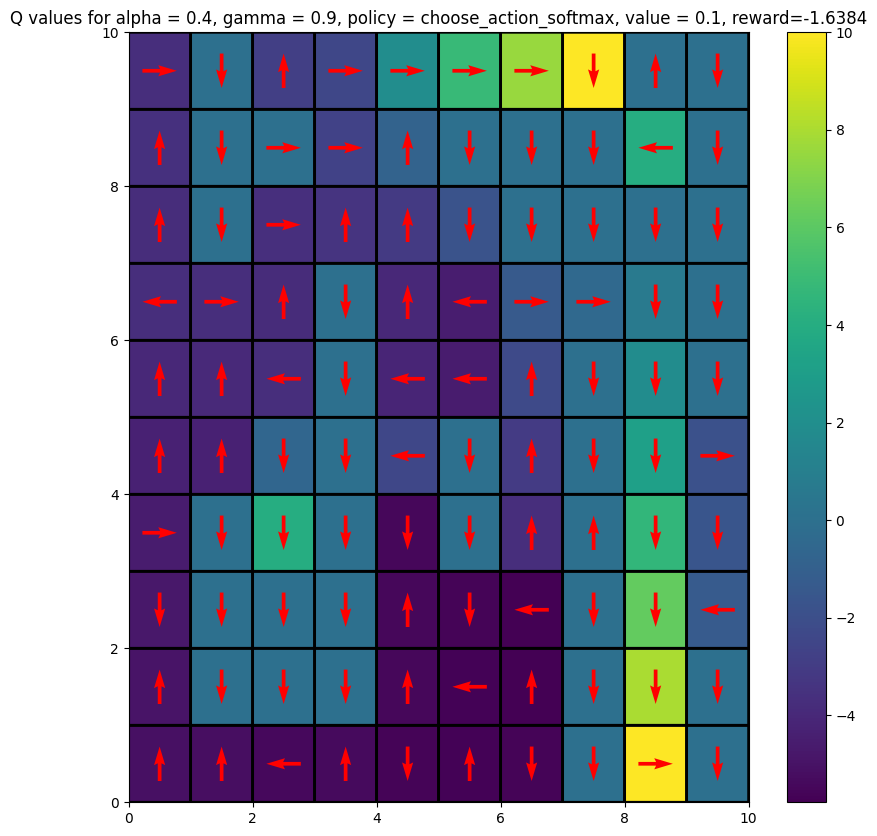

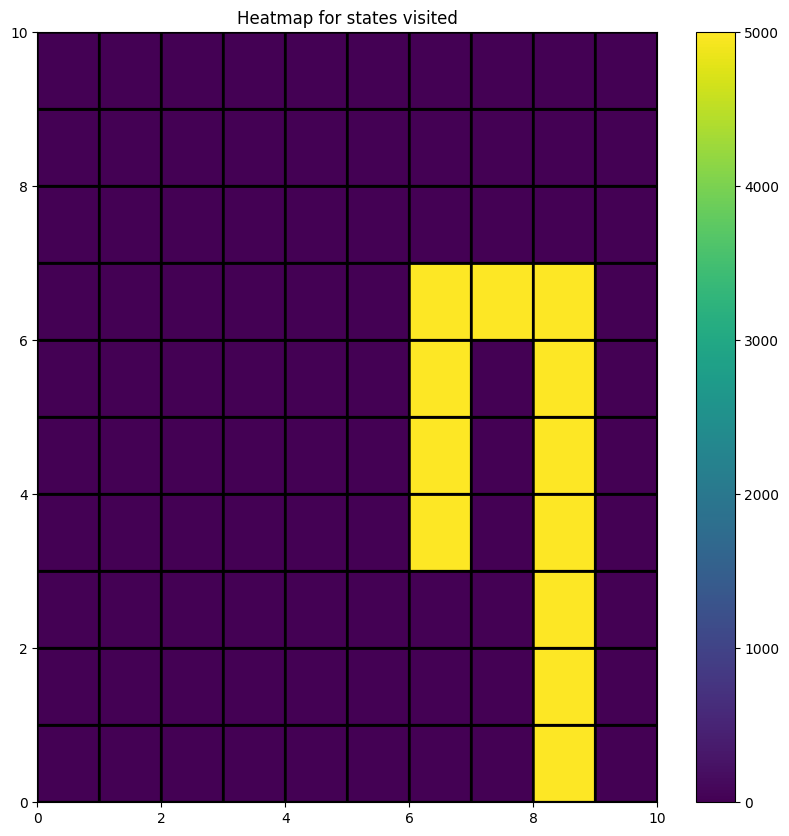

(3, 6) False 0.7
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:10<00:00, 455.76it/s]


Best reward:-106.1932
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:10<00:00, 467.90it/s]


Best reward:-115.7738
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 469.01it/s]


Best reward:-125.4024
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:23<00:00, 209.44it/s]


Best reward:-76.0832
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:24<00:00, 203.53it/s]


Best reward:-80.4344
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:26<00:00, 188.67it/s]


Best reward:-88.6604
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 691.53it/s]


Best reward:-81.6286
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:10<00:00, 480.61it/s]


Best reward:-113.5132
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 488.79it/s]


Best reward:-121.9394
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:15<00:00, 320.38it/s]


Best reward:-46.9326
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:21<00:00, 232.52it/s]


Best reward:-67.0896
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 208.96it/s]


Best reward:-80.4126
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1317.87it/s]


Best reward:-37.1234
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:05<00:00, 939.33it/s] 


Best reward:-61.8124
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 713.66it/s] 


Best reward:-84.0398
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 573.98it/s]


Best reward:-23.1058
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:10<00:00, 456.76it/s]


Best reward:-27.9792
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:17<00:00, 290.70it/s]


Best reward:-51.7192
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 507.13it/s]


Best reward:-102.3208
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:10<00:00, 481.71it/s]


Best reward:-117.1252
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 485.39it/s]


Best reward:-125.1518
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:23<00:00, 215.15it/s]


Best reward:-73.6704
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:24<00:00, 201.31it/s]


Best reward:-80.8318
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 196.17it/s]


Best reward:-87.8494
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 542.27it/s]


Best reward:-99.3324
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:10<00:00, 499.40it/s]


Best reward:-110.6174
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 494.37it/s]


Best reward:-126.0684
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:16<00:00, 308.00it/s]


Best reward:-49.0144
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:19<00:00, 250.97it/s]


Best reward:-63.7708
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 214.05it/s]


Best reward:-77.6718
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1405.07it/s]


Best reward:-39.6774
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:05<00:00, 916.21it/s] 


Best reward:-68.9132
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 601.38it/s]


Best reward:-95.0822
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 585.30it/s]


Best reward:-21.646
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:09<00:00, 555.19it/s]


Best reward:-24.7886
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 324.40it/s]


Best reward:-50.928
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 543.87it/s]


Best reward:-108.5422
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:09<00:00, 527.70it/s]


Best reward:-122.663
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 561.31it/s]


Best reward:-129.7068
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:22<00:00, 224.18it/s]


Best reward:-76.5332
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:23<00:00, 215.08it/s]


Best reward:-81.6624
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 206.59it/s]


Best reward:-86.95
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 604.37it/s]


Best reward:-100.6118
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 571.45it/s]


Best reward:-118.7442
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 565.07it/s]


Best reward:-128.5276
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:15<00:00, 332.70it/s]


Best reward:-48.829
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:18<00:00, 265.81it/s]


Best reward:-65.0766
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:22<00:00, 224.47it/s]


Best reward:-80.0274
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 906.55it/s] 


Best reward:-61.2532
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 671.88it/s]


Best reward:-92.5632
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 607.51it/s]


Best reward:-119.4788
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 591.28it/s]


Best reward:-21.8582
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:11<00:00, 441.14it/s]


Best reward:-30.0834
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:16<00:00, 311.97it/s]


Best reward:-50.7732
(0.2, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:08<00:00, 619.20it/s]


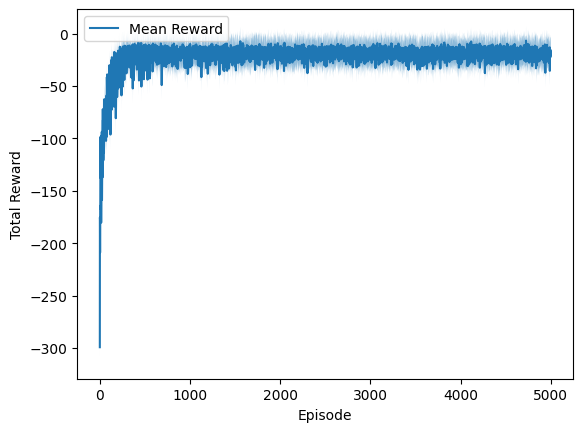

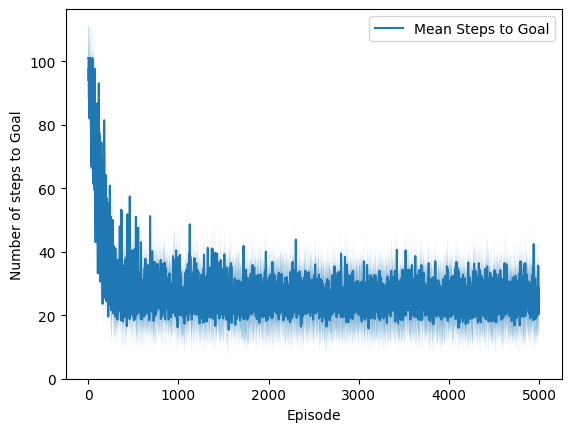

100%|██████████| 5000/5000 [00:07<00:00, 707.36it/s]


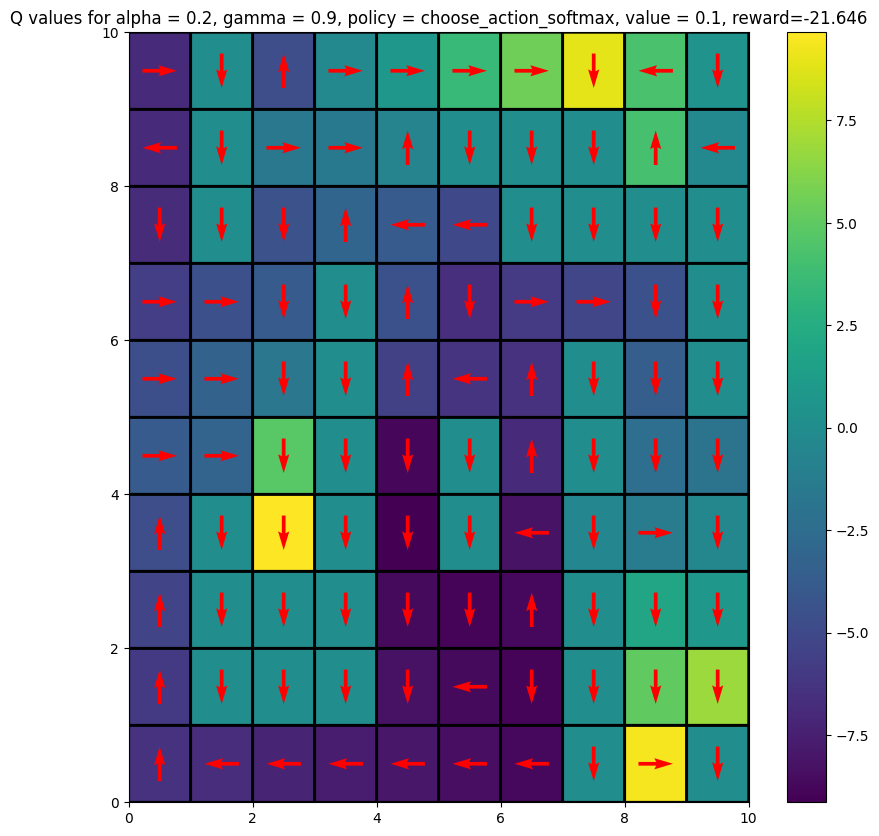

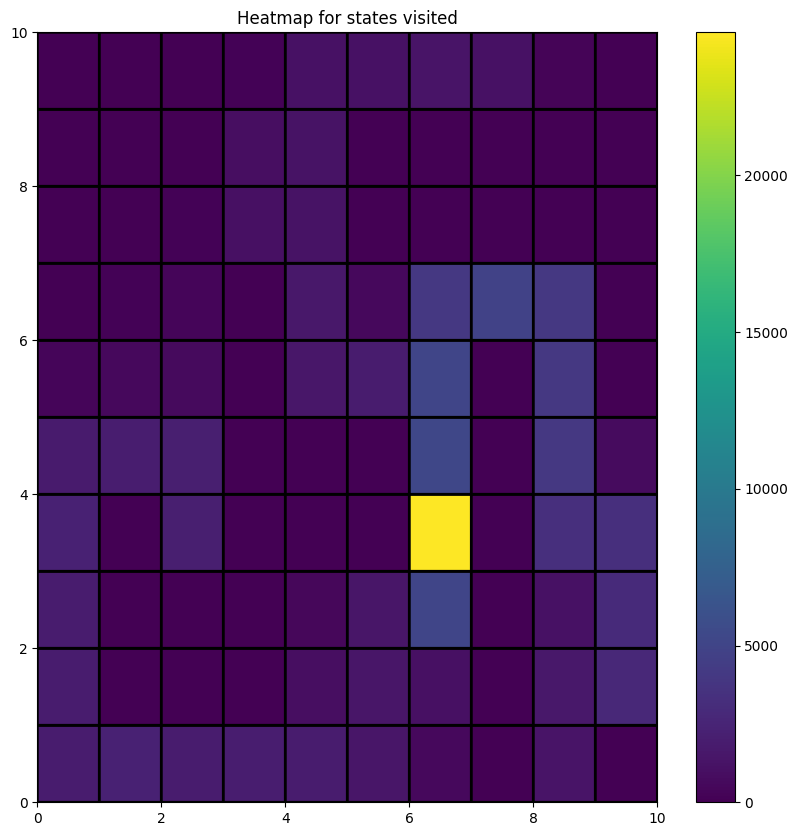

(3, 6) True 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2107.11it/s]


Best reward:-20.6282
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:05<00:00, 834.69it/s] 


Best reward:-79.4948
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 749.36it/s] 


Best reward:-91.1434
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 595.95it/s]


Best reward:-22.4326
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:16<00:00, 311.86it/s]


Best reward:-50.4286
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 252.87it/s]


Best reward:-63.803
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2297.22it/s]


Best reward:-20.6004
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1929.18it/s]


Best reward:-32.162
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1533.79it/s]


Best reward:-49.0568
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1185.47it/s]


Best reward:-5.9496
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 899.19it/s] 


Best reward:-10.7112
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:16<00:00, 306.10it/s]


Best reward:-51.9098
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:01<00:00, 2506.86it/s]


Best reward:-16.5496
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1976.61it/s]


Best reward:-30.5416
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1621.80it/s]


Best reward:-46.6462
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1222.31it/s]


Best reward:-5.5476
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:04<00:00, 1188.22it/s]


Best reward:-5.7722
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:05<00:00, 892.53it/s] 


Best reward:-11.774
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 893.75it/s] 


Best reward:-67.9486
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 827.78it/s] 


Best reward:-73.094
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 745.58it/s]


Best reward:-88.4148
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 638.65it/s]


Best reward:-21.5826
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:16<00:00, 304.21it/s]


Best reward:-52.6432
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 253.67it/s]


Best reward:-62.8614
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2297.30it/s]


Best reward:-20.0694
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1772.50it/s]


Best reward:-34.9424
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1106.00it/s]


Best reward:-63.4528
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1339.92it/s]


Best reward:-5.9152
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 861.37it/s] 


Best reward:-12.9336
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 326.65it/s]


Best reward:-51.238
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2332.20it/s]


Best reward:-20.4028
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 2126.39it/s]


Best reward:-30.049
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1592.07it/s]


Best reward:-49.437
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1279.95it/s]


Best reward:-5.6164
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:03<00:00, 1296.65it/s]


Best reward:-6.0
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:05<00:00, 927.58it/s] 


Best reward:-9.8814
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 597.22it/s] 


Best reward:-81.0094
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 698.16it/s] 


Best reward:-83.1006
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 562.89it/s]


Best reward:-105.1018
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 538.53it/s]


Best reward:-27.0296
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:16<00:00, 311.91it/s]


Best reward:-51.075
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 259.37it/s]


Best reward:-62.3732
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1753.51it/s]


Best reward:-25.7718
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1259.14it/s]


Best reward:-47.3254
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 789.37it/s] 


Best reward:-82.6426
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1270.23it/s]


Best reward:-3.9768
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 904.56it/s] 


Best reward:-10.7934
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 323.47it/s]


Best reward:-48.1524
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2082.04it/s]


Best reward:-21.343
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1668.10it/s]


Best reward:-36.4324
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1372.06it/s]


Best reward:-54.5922
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1402.15it/s]


Best reward:-4.5964
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:03<00:00, 1360.84it/s]


Best reward:-4.7098
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:05<00:00, 927.18it/s] 


Best reward:-9.513
(0.4, 0.8, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:03<00:00, 1353.48it/s]


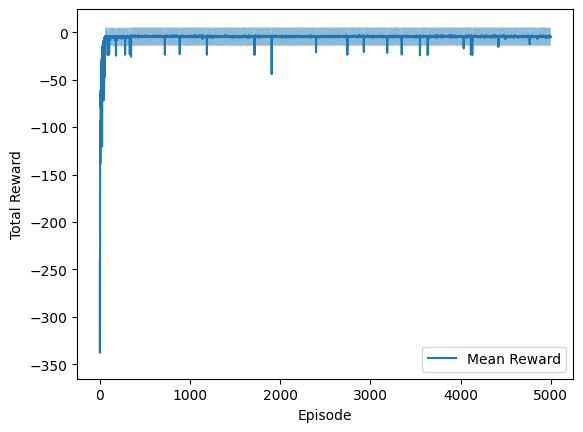

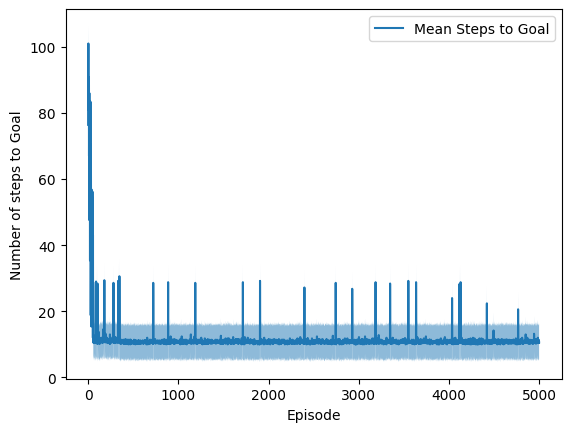

100%|██████████| 5000/5000 [00:03<00:00, 1369.05it/s]


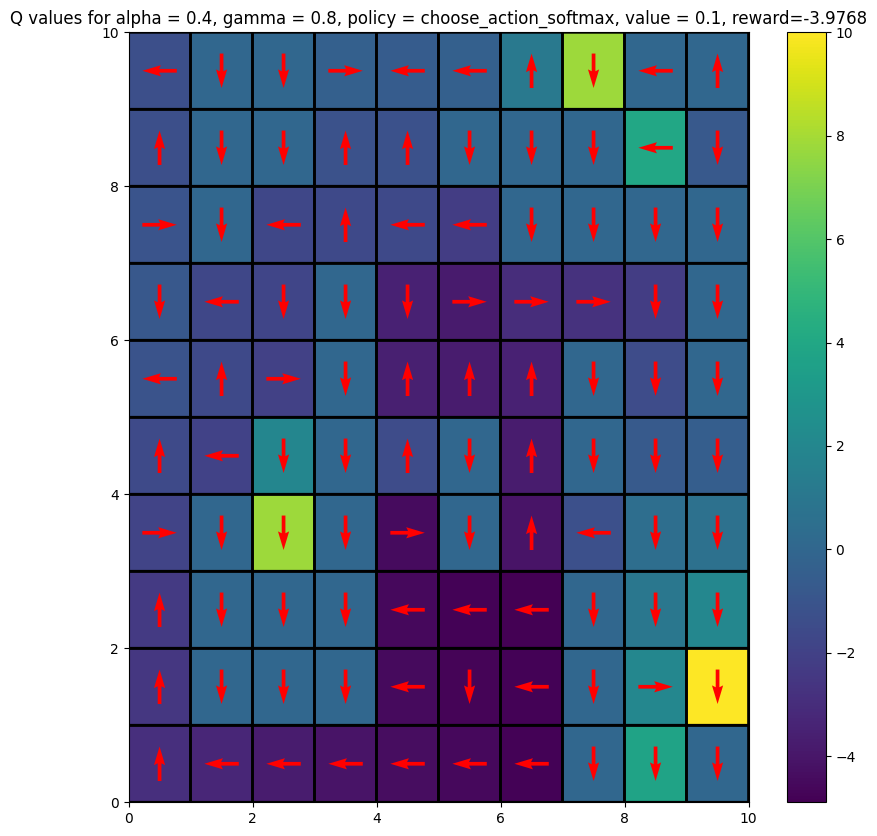

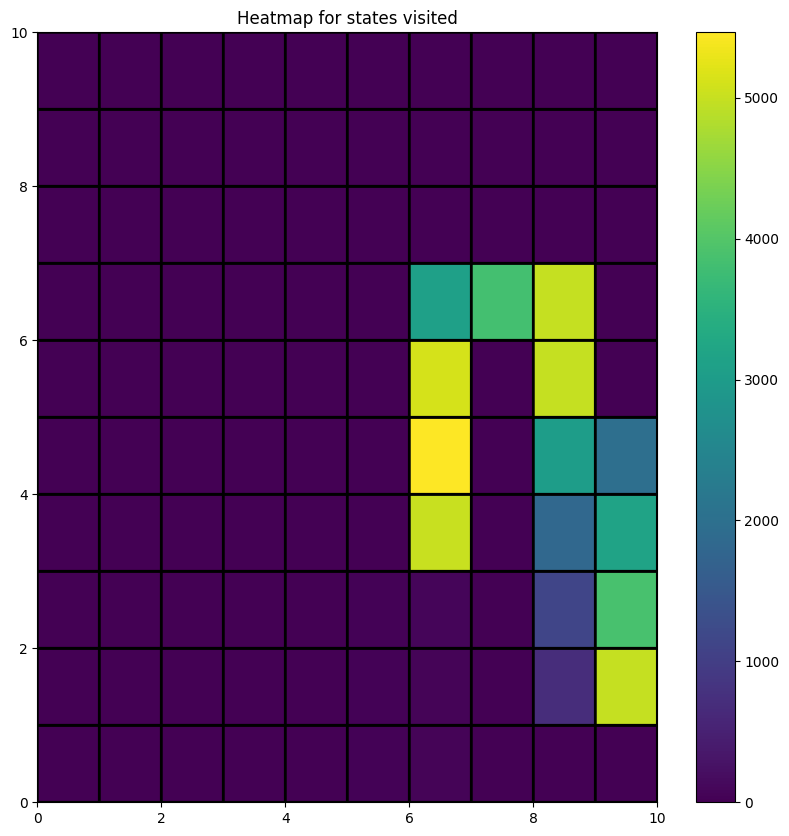

In [24]:
for start, (wind, transition) in init_states:
    print(start, wind, transition)
    env.wind = wind
    env.p_good_trans = transition
    env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
    env = env.create_gridworld()
    # print(env.goal_states_se)

    episodes = 5000   
    best_reward = -np.inf
    best_params = None

    best_reward_avgs = []
    best_step_avgs = [] 

    
    for a, g, (p, val) in params:
        print(a, g, p, val)
        
        # all_rewards = []
        # all_steps = []    
        Q = np.zeros((num_rows, num_cols, 4))
        # rewards, steps = None, None
        # heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        # for i in range(5):
        #     Q = np.zeros((num_rows, num_cols, 4))
        #     heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        #     all_rewards.append(rewards)
        #     all_steps.append(steps)

        
        heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        # find the best reward
        # avg_reward = (sum(all_rewards)/5)[4000:].mean()
        regret = rewards.mean()
        # show_rewards_steps(all_steps, all_rewards)
        print(f"Best reward:{regret}")
        if best_reward < regret:
            best_reward = regret
            best_params = a, g, (p, val)
            # best_reward_avgs = all_rewards
            # best_step_avgs = all_steps
    
    a, g, (p, val) = best_params

    print(best_params)
    for i in range(5):
        Q = np.zeros((num_rows, num_cols, 4))
        heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        best_reward_avgs.append(rewards)
        best_step_avgs.append(steps)
    show_rewards_steps(best_step_avgs, best_reward_avgs)
    heatmap, _, _ = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
    plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}, reward={best_reward}")
    plot_heatmap(heatmap, "Heatmap for states visited")
    # sarsa(Q, env, start, (choose_action_epsilon, 0.2), 0.4, 0.999, episodes)

# Q Learning 

In [18]:
# constants
def Qlearning(Q, env, start_state, policy, alpha, gamma, episodes, plot=True):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    heatmap = np.zeros((num_rows, num_cols))

    for episode in tqdm(range(episodes)):
        state = env.reset()
        state_rc = seq_to_col_row(state, num_cols)[0]
        action = policy[0](Q, state_rc, policy[1])
        done = False
        rewards = 0
        steps = 0
        while not done and steps <= 100:
            heatmap[state_rc[0], state_rc[1]] += 1
            next_state, reward = env.step(state, action)
            done = (next_state in env.goal_states_seq)
            next_state_rc = seq_to_col_row(next_state, num_cols)[0]
            # print(next_state, next_state_rc)
            # if d?one:
                # print(state_rc, next_state_rc, action, reward)
            next_action = policy[0](Q, next_state_rc, policy[1])
            best_action = argmax_4(Q[next_state_rc[0], next_state_rc[1]])
            Q[state_rc[0], state_rc[1], action] += alpha * (reward[0] + gamma * (Q[next_state_rc[0], next_state_rc[1], best_action]) - Q[state_rc[0], state_rc[1], action])
            state = next_state
            state_rc = next_state_rc
            action = next_action
            rewards += reward[0]
            steps += 1
            # print(env.goal_states_seq)
        episode_rewards[episode] = rewards
        steps_to_completion[episode] = steps
        # print(steps)
        if episode % 100 == 0 and plot:
            clear_output(wait=True)
            plot_Q(Q, f"Q values for policy = {policy[0].__name__}, value = {policy[1]}: reward={episode_rewards[episode]}, steps={steps_to_completion[episode]}")
    return heatmap, episode_rewards, steps_to_completion

In [22]:
start, (wind, transition) = init_states[4]
# print(start, wind, transition)
env.wind = wind
env.p_good_trans = transition
env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
env = env.create_gridworld()
    # print(env.goal_states_se)

Q = np.zeros((num_rows, num_cols, 4))
episodes = 10000   

    # for a, g, (p, val) in params:
    #     print(a, g, p, val)
    #     sarsa(Q, env, start, (p, val), a, g, episodes)
    #     plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}")
Qlearning(Q, env, start, (choose_action_softmax, 0.5), 0.5, 0.99, episodes)

(3, 6) False 0.7


9 0


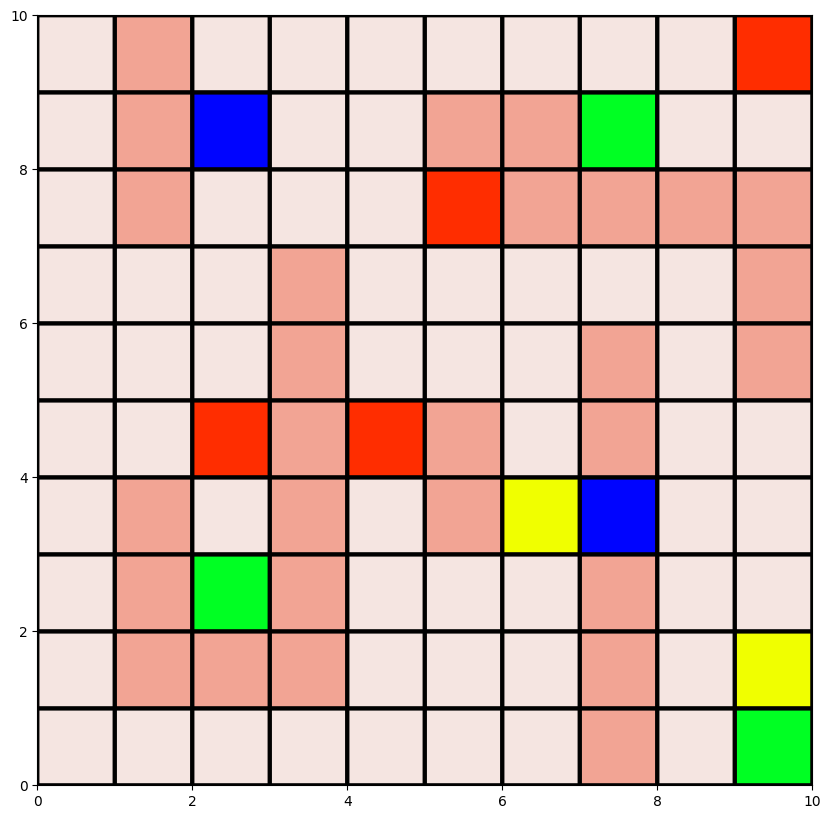

Steps: 20, Total Reward: -14


/tmp/ipykernel_1866/3443224119.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


In [20]:

state = env.reset()
done = False
steps = 0
tot_reward = 0
while not done:
    clear_output(wait=True)
    # print(state)
    state_rc = seq_to_col_row(state, num_cols)[0]
    state, reward= env.step(state, Q[state_rc[0], state_rc[1]].argmax())
    print(state, Q[state_rc[0], state_rc[1]].argmax())
    done = (state in env.goal_states_seq)
    plt.figure(figsize=(10, 10))
    env.render(cur_state=state_rc)
    plt.show()
    steps += 1
    tot_reward += reward
    sleep(0.2)
print("Steps: %d, Total Reward: %d"%(steps, tot_reward))

(0, 4) False 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_1866/1847332907.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state_rc[0], state_rc[1], action] += alpha * (reward + gamma * (Q[next_state_rc[0], next_state_rc[1], best_action]) - Q[state_rc[0], state_rc[1], action])
/tmp/ipykernel_1866/1847332907.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  episode_rewards[episode] = rewards
100%|██████████| 5000/5000 [00:03<00:00, 1345.73it/s]


Best reward:-14.1072
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1063.65it/s]


Best reward:-21.5578
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 884.34it/s] 


Best reward:-32.668
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:17<00:00, 289.64it/s]


Best reward:-36.0866
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:26<00:00, 190.49it/s]


Best reward:-63.6786
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:28<00:00, 173.55it/s]


Best reward:-78.2498
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1409.60it/s]


Best reward:-12.5224
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1289.60it/s]


Best reward:-16.4834
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 984.47it/s] 


Best reward:-29.333
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 642.00it/s] 


Best reward:-10.6158
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:10<00:00, 496.81it/s]


Best reward:-18.706
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:20<00:00, 246.13it/s]


Best reward:-47.875
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2388.66it/s]


Best reward:-10.4308
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 2052.95it/s]


Best reward:-13.8412
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1080.46it/s]


Best reward:-30.2862
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 864.70it/s] 


Best reward:-8.4572
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 878.90it/s] 


Best reward:-9.1308
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:10<00:00, 495.61it/s]


Best reward:-20.1664
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1221.66it/s]


Best reward:-12.848
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1112.68it/s]


Best reward:-20.3954
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 925.02it/s] 


Best reward:-30.9888
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:17<00:00, 291.36it/s]


Best reward:-34.911
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:23<00:00, 217.06it/s]


Best reward:-56.9598
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:29<00:00, 167.29it/s]


Best reward:-77.4256
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1228.15it/s]


Best reward:-12.7412
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1025.89it/s]


Best reward:-20.2978
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 926.75it/s] 


Best reward:-29.9222
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 609.67it/s]


Best reward:-9.6282
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:09<00:00, 519.13it/s]


Best reward:-16.9046
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:19<00:00, 252.91it/s]


Best reward:-46.7146
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 2036.86it/s]


Best reward:-9.5216
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 2017.53it/s]


Best reward:-12.0862
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 1702.32it/s]


Best reward:-16.5216
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 994.54it/s] 


Best reward:-7.3362
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 660.89it/s]


Best reward:-7.9494
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:10<00:00, 490.96it/s]


Best reward:-18.9848
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1224.87it/s]


Best reward:-12.6126
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1093.04it/s]


Best reward:-19.7496
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 930.22it/s] 


Best reward:-30.9772
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:16<00:00, 302.68it/s]


Best reward:-34.1576
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:24<00:00, 200.02it/s]


Best reward:-62.3146
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:28<00:00, 176.91it/s]


Best reward:-77.206
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1318.44it/s]


Best reward:-12.5122
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1450.48it/s]


Best reward:-15.9978
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 1678.16it/s]


Best reward:-17.3928
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 618.73it/s]


Best reward:-9.2726
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:11<00:00, 445.31it/s]


Best reward:-19.976
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:18<00:00, 266.25it/s]


Best reward:-46.111
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1336.93it/s]


Best reward:-12.3136
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1129.34it/s]


Best reward:-18.9982
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:02<00:00, 1752.65it/s]


Best reward:-16.3066
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 687.04it/s]


Best reward:-6.8824
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 683.12it/s]


Best reward:-7.4064
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:09<00:00, 518.27it/s]


Best reward:-18.5822
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:07<00:00, 691.61it/s]


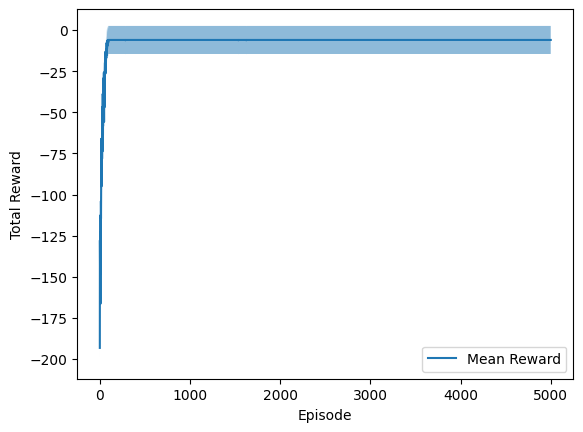

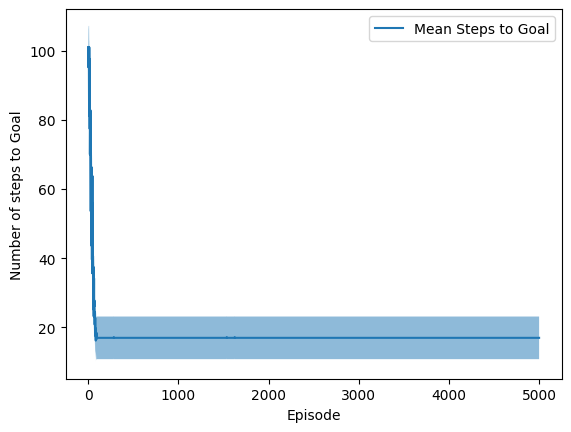

100%|██████████| 5000/5000 [00:05<00:00, 865.20it/s] 


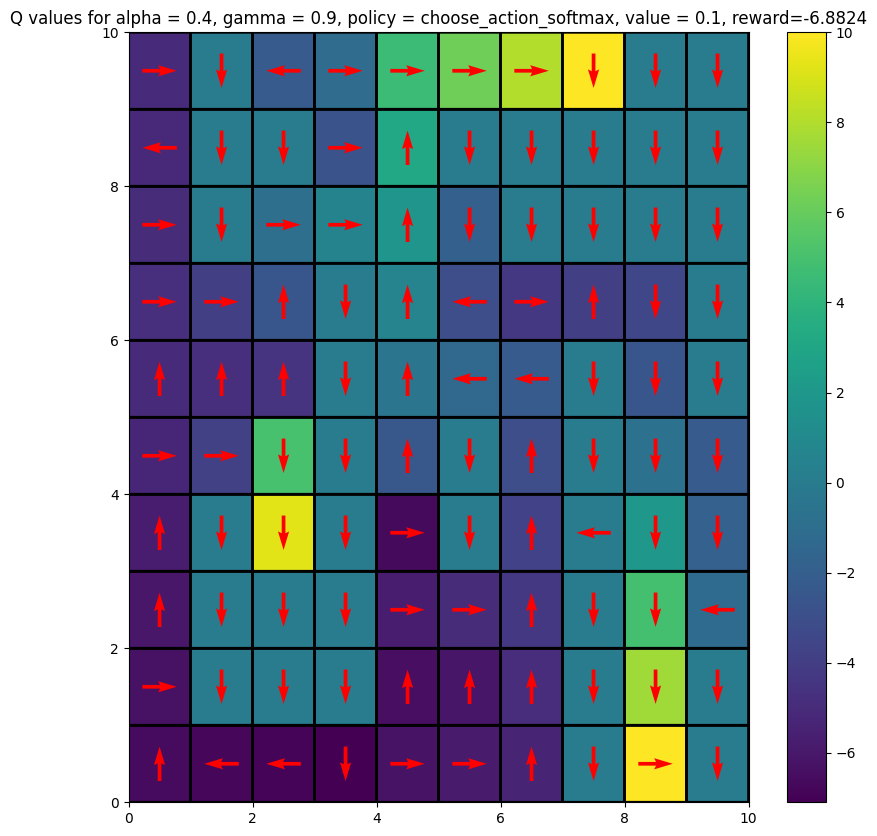

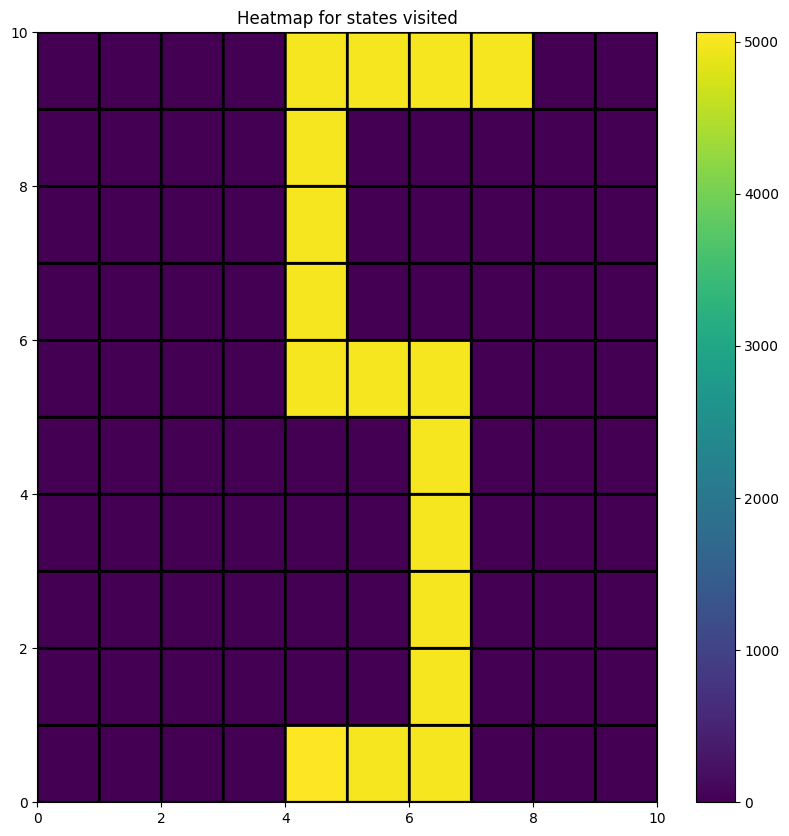

(0, 4) False 0.7
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 651.78it/s]


Best reward:-58.8758
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 570.79it/s]


Best reward:-88.3646
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 490.86it/s]


Best reward:-119.77
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:33<00:00, 148.86it/s]


Best reward:-94.2948
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:33<00:00, 147.60it/s]


Best reward:-95.2684
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:33<00:00, 149.46it/s]


Best reward:-96.9168
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 666.43it/s]


Best reward:-57.3806
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1005.11it/s]


Best reward:-33.2704
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:05<00:00, 949.99it/s] 


Best reward:-39.6286
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:23<00:00, 212.02it/s]


Best reward:-63.7526
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:29<00:00, 171.96it/s]


Best reward:-81.1096
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:31<00:00, 159.66it/s]


Best reward:-90.5486
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1369.02it/s]


Best reward:-23.355
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1202.65it/s]


Best reward:-28.2984
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1042.29it/s]


Best reward:-34.677
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 583.98it/s]


Best reward:-20.8442
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:13<00:00, 382.51it/s]


Best reward:-33.3422
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 203.63it/s]


Best reward:-68.2304
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 651.94it/s]


Best reward:-58.1328
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 572.03it/s]


Best reward:-91.4138
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 501.61it/s]


Best reward:-119.4042
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:33<00:00, 151.39it/s]


Best reward:-93.7716
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:33<00:00, 147.17it/s]


Best reward:-94.6254
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:34<00:00, 146.02it/s]


Best reward:-96.8168
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 676.50it/s]


Best reward:-55.1742
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 719.40it/s] 


Best reward:-61.9402
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 588.06it/s]


Best reward:-88.4172
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:30<00:00, 163.39it/s]


Best reward:-82.2788
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:28<00:00, 175.04it/s]


Best reward:-80.0492
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:31<00:00, 158.26it/s]


Best reward:-90.1654
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1372.71it/s]


Best reward:-23.9916
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:04<00:00, 1209.52it/s]


Best reward:-27.8382
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1042.35it/s]


Best reward:-34.6728
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 630.14it/s]


Best reward:-19.063
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:11<00:00, 449.96it/s]


Best reward:-28.5052
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 208.83it/s]


Best reward:-65.4818
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 606.59it/s]


Best reward:-62.6974
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:09<00:00, 511.36it/s]


Best reward:-95.1038
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 456.52it/s]


Best reward:-124.1788
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:33<00:00, 150.28it/s]


Best reward:-93.6086
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:32<00:00, 152.46it/s]


Best reward:-95.2054
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:33<00:00, 149.33it/s]


Best reward:-96.7944
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 617.35it/s]


Best reward:-62.0622
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 557.16it/s]


Best reward:-87.7696
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:10<00:00, 494.36it/s]


Best reward:-110.4186
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:32<00:00, 156.23it/s]


Best reward:-84.7076
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:32<00:00, 151.67it/s]


Best reward:-89.2638
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:32<00:00, 151.96it/s]


Best reward:-91.4964
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1057.24it/s]


Best reward:-29.254
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:05<00:00, 905.31it/s] 


Best reward:-38.55
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 805.81it/s] 


Best reward:-43.1542
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:12<00:00, 412.73it/s]


Best reward:-26.1218
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:14<00:00, 335.39it/s]


Best reward:-35.7512
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 198.06it/s]


Best reward:-66.2
(0.2, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:07<00:00, 641.24it/s]


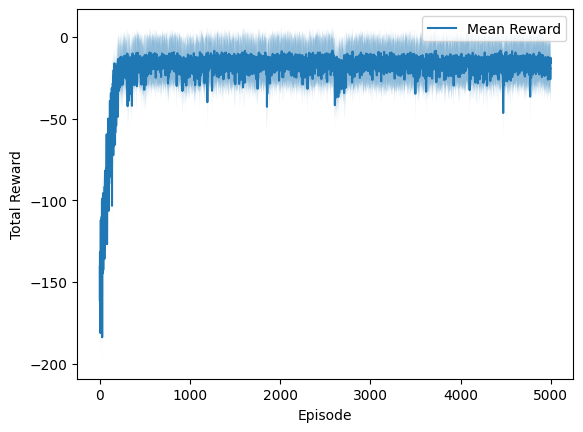

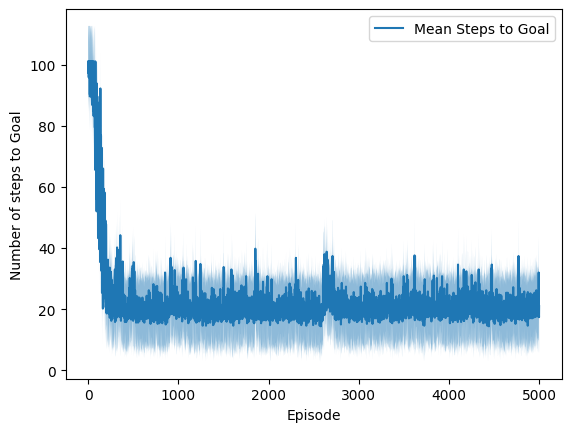

100%|██████████| 5000/5000 [00:05<00:00, 916.48it/s] 


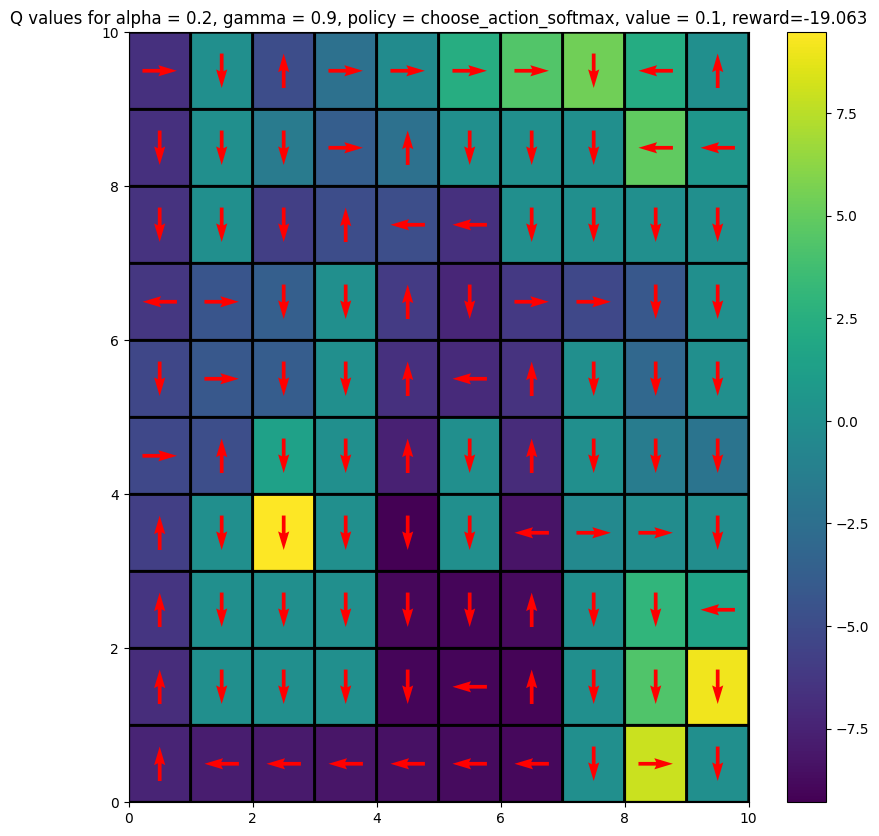

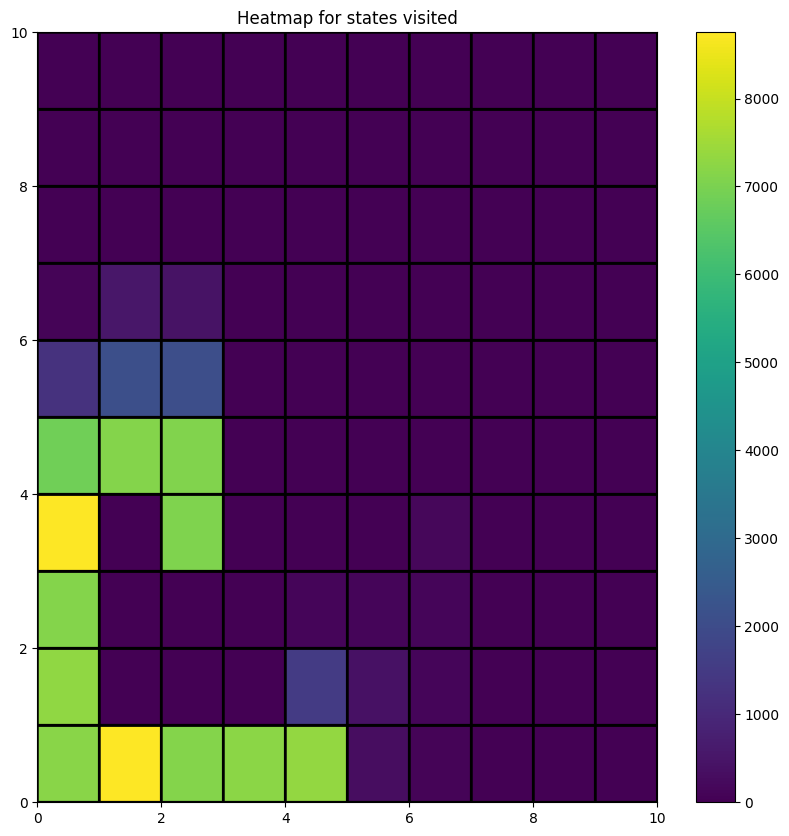

(0, 4) True 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1588.41it/s]


Best reward:-13.8594
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1334.76it/s]


Best reward:-18.4498
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1074.31it/s]


Best reward:-25.2538
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:37<00:00, 134.67it/s]


Best reward:-98.451
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:38<00:00, 131.07it/s]


Best reward:-100.4912
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:38<00:00, 130.94it/s]


Best reward:-100.9234
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1674.68it/s]


Best reward:-13.2534
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1362.93it/s]


Best reward:-17.643
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1140.79it/s]


Best reward:-24.2876
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:10<00:00, 477.11it/s]


Best reward:-22.0314
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 161.63it/s]


Best reward:-79.6706
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:37<00:00, 131.61it/s]


Best reward:-100.2952
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1649.04it/s]


Best reward:-13.1296
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1400.45it/s]


Best reward:-17.275
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1128.52it/s]


Best reward:-24.0378
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 818.71it/s] 


Best reward:-10.1596
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 731.85it/s]


Best reward:-11.7666
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:25<00:00, 192.75it/s]


Best reward:-64.9952
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1661.97it/s]


Best reward:-12.536
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1419.84it/s]


Best reward:-17.0126
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1085.67it/s]


Best reward:-23.4974
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:37<00:00, 133.75it/s]


Best reward:-98.3594
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:37<00:00, 131.68it/s]


Best reward:-100.7088
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:38<00:00, 131.44it/s]


Best reward:-100.9414
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1758.36it/s]


Best reward:-12.2868
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1436.39it/s]


Best reward:-16.4408
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1177.12it/s]


Best reward:-22.508
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 535.45it/s]


Best reward:-19.4432
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 165.92it/s]


Best reward:-79.7264
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:36<00:00, 136.65it/s]


Best reward:-99.6122
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1733.05it/s]


Best reward:-12.1882
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1447.67it/s]


Best reward:-16.3306
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1182.88it/s]


Best reward:-22.4152
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 874.99it/s] 


Best reward:-9.3108
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 843.93it/s] 


Best reward:-10.234
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 200.50it/s]


Best reward:-64.051
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1668.50it/s]


Best reward:-12.522
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1403.71it/s]


Best reward:-16.752
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1142.11it/s]


Best reward:-23.2924
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:37<00:00, 133.35it/s]


Best reward:-100.0242
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:37<00:00, 132.86it/s]


Best reward:-100.3938
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:37<00:00, 133.03it/s]


Best reward:-101.009
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1720.76it/s]


Best reward:-12.2806
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1450.55it/s]


Best reward:-16.478
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1205.52it/s]


Best reward:-23.3764
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 599.42it/s]


Best reward:-16.3094
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 166.58it/s]


Best reward:-78.347
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:37<00:00, 132.55it/s]


Best reward:-100.064
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1702.69it/s]


Best reward:-11.9594
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1493.53it/s]


Best reward:-16.3966
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1216.99it/s]


Best reward:-22.7266
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 872.33it/s] 


Best reward:-8.914
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 823.57it/s] 


Best reward:-9.4152
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 204.09it/s]


Best reward:-61.8502
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:05<00:00, 871.01it/s] 


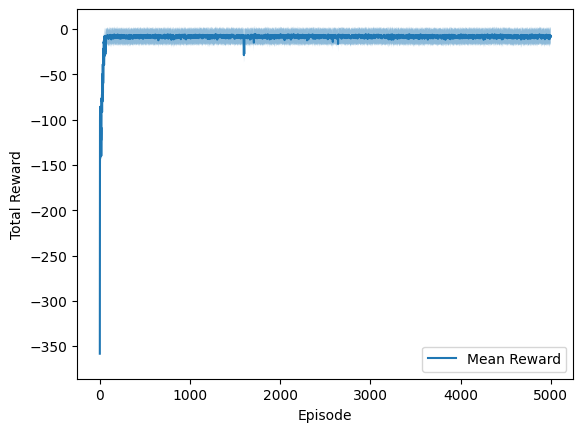

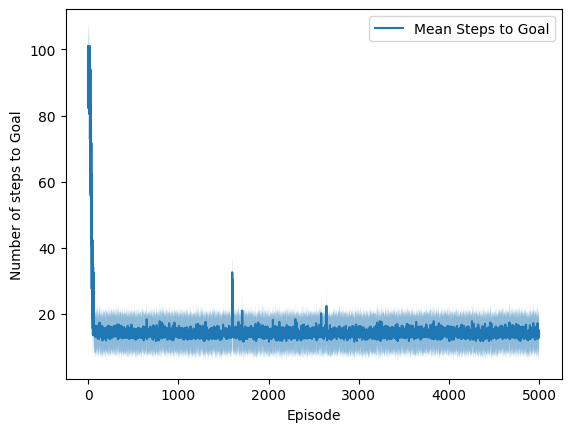

100%|██████████| 5000/5000 [00:04<00:00, 1143.73it/s]


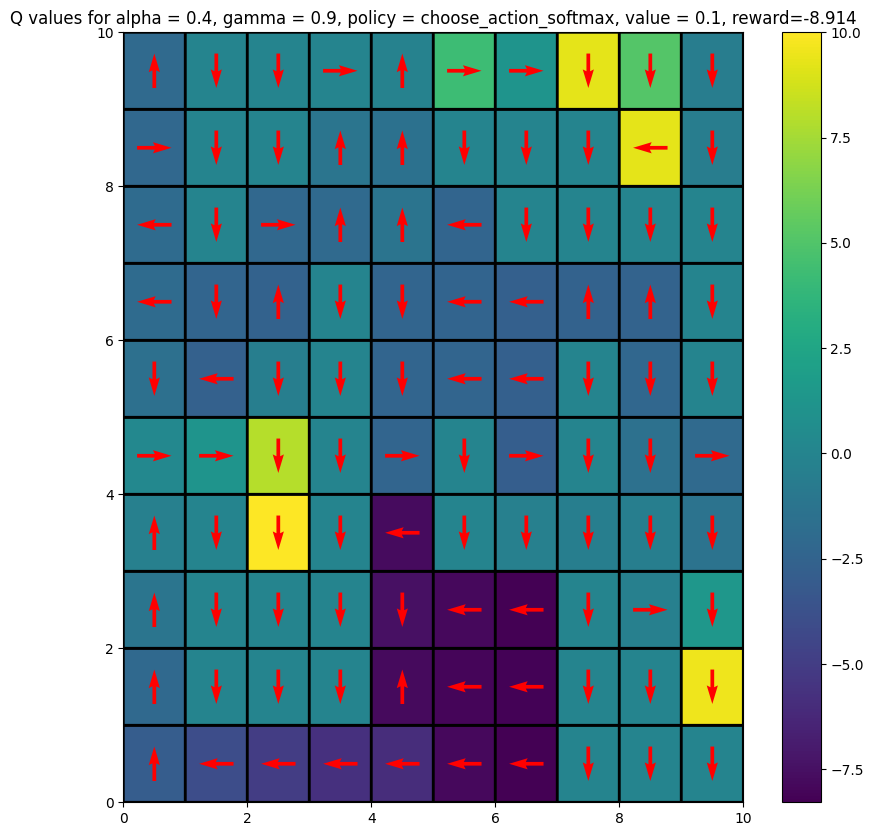

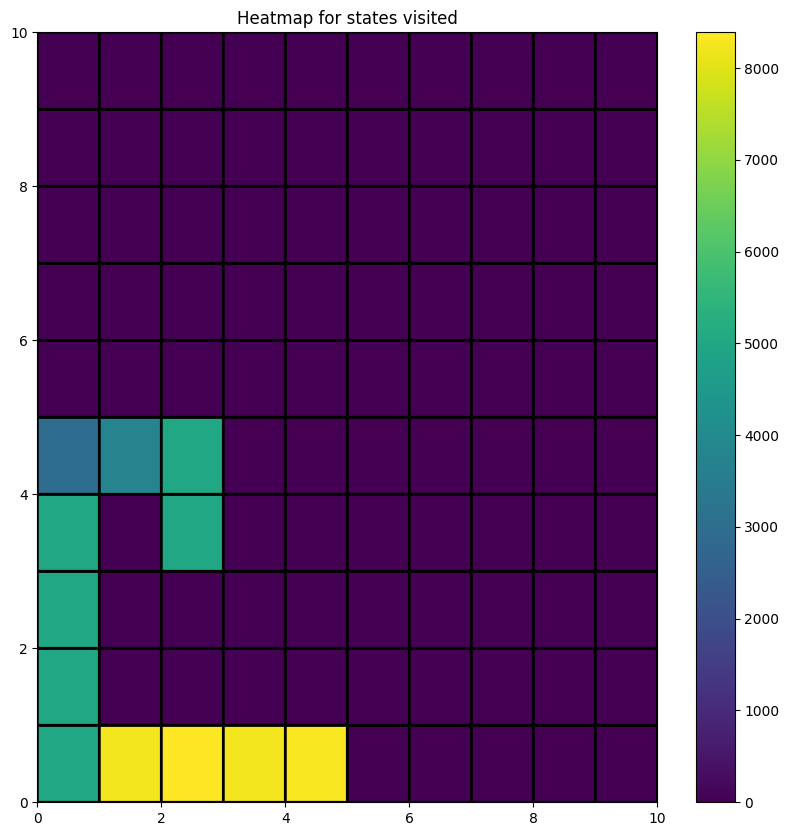

(3, 6) False 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1616.85it/s]


Best reward:-8.038
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1338.79it/s]


Best reward:-14.5496
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1285.10it/s]


Best reward:-23.063
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 679.83it/s]


Best reward:-8.5468
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:13<00:00, 368.47it/s]


Best reward:-25.9842
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:21<00:00, 227.71it/s]


Best reward:-52.3006
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1511.65it/s]


Best reward:-7.6798
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1396.23it/s]


Best reward:-14.9654
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1186.27it/s]


Best reward:-23.587
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 834.78it/s] 


Best reward:-3.513
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 730.35it/s]


Best reward:-6.1284
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:13<00:00, 378.78it/s]


Best reward:-24.3536
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1576.73it/s]


Best reward:-7.5526
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1390.34it/s]


Best reward:-14.5968
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1186.27it/s]


Best reward:-22.516
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 868.60it/s] 


Best reward:-3.053
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 817.71it/s] 


Best reward:-3.4658
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:07<00:00, 650.70it/s]


Best reward:-8.0176
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1643.10it/s]


Best reward:-7.1872
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1424.22it/s]


Best reward:-13.9932
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:04<00:00, 1228.56it/s]


Best reward:-24.0116
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 685.60it/s]


Best reward:-7.187
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:12<00:00, 388.86it/s]


Best reward:-24.102
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:20<00:00, 240.76it/s]


Best reward:-49.9898
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1599.12it/s]


Best reward:-6.9244
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1548.65it/s]


Best reward:-13.0016
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1264.85it/s]


Best reward:-23.334
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 875.98it/s] 


Best reward:-2.4218
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 787.53it/s]


Best reward:-4.9542
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:12<00:00, 404.94it/s]


Best reward:-22.6734
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:03<00:00, 1632.31it/s]


Best reward:-6.8096
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1451.22it/s]


Best reward:-13.8432
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1292.22it/s]


Best reward:-22.279
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 910.16it/s] 


Best reward:-2.2028
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 883.04it/s] 


Best reward:-2.2846
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:07<00:00, 693.54it/s]


Best reward:-6.7338
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1707.82it/s]


Best reward:-6.4758
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1499.99it/s]


Best reward:-13.133
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1282.82it/s]


Best reward:-21.3146
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 703.14it/s]


Best reward:-6.703
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:12<00:00, 402.25it/s]


Best reward:-23.334
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:20<00:00, 241.61it/s]


Best reward:-49.5688
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1683.03it/s]


Best reward:-6.2058
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1469.41it/s]


Best reward:-12.8508
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1396.36it/s]


Best reward:-23.055
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 916.74it/s] 


Best reward:-1.8818
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 789.51it/s]


Best reward:-4.1946
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:12<00:00, 392.58it/s]


Best reward:-22.9224
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1695.94it/s]


Best reward:-6.4
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1387.19it/s]


Best reward:-12.7112
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1293.67it/s]


Best reward:-21.3104
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 933.28it/s] 


Best reward:-1.6726
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 945.45it/s] 


Best reward:-1.7068
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:07<00:00, 709.13it/s]


Best reward:-6.4602
(0.4, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:05<00:00, 912.06it/s] 


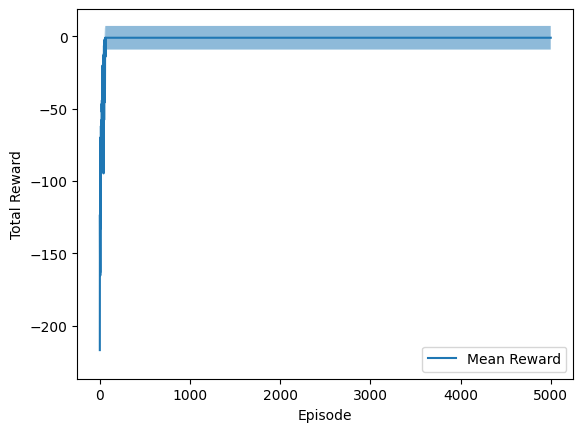

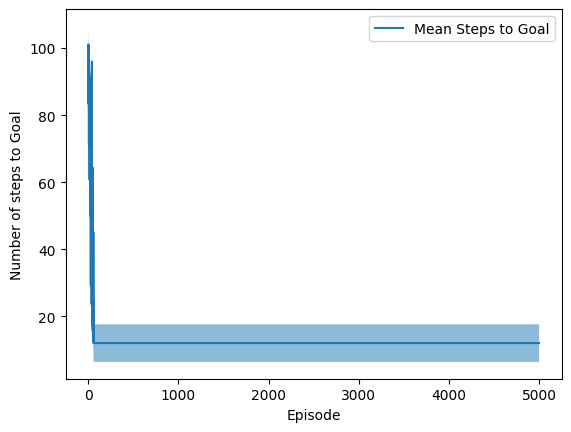

100%|██████████| 5000/5000 [00:04<00:00, 1139.12it/s]


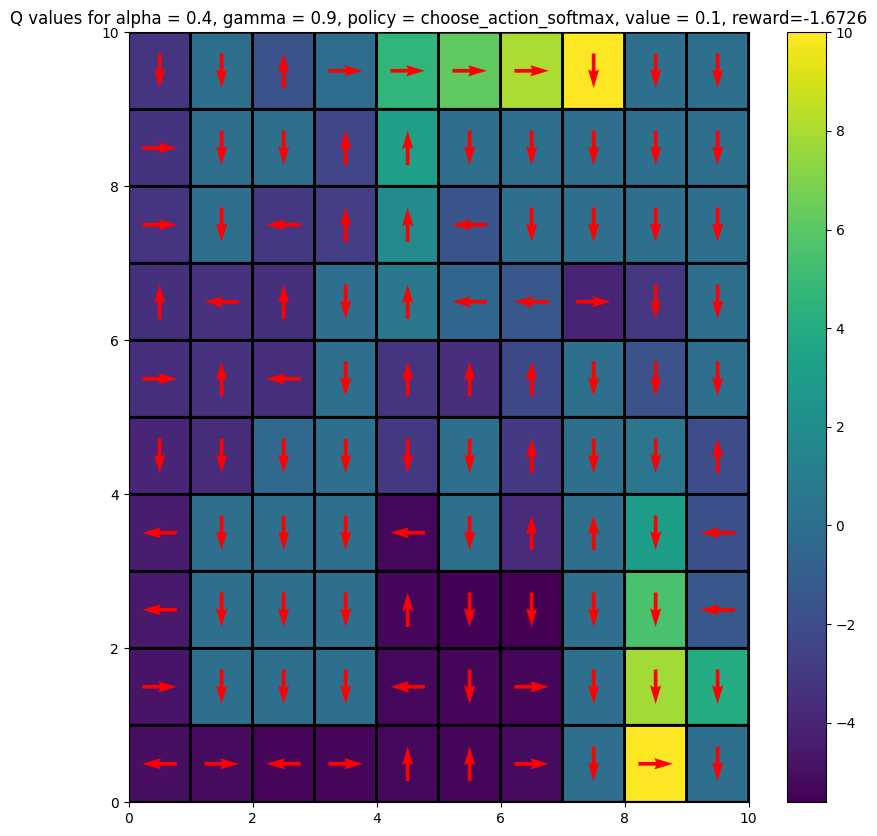

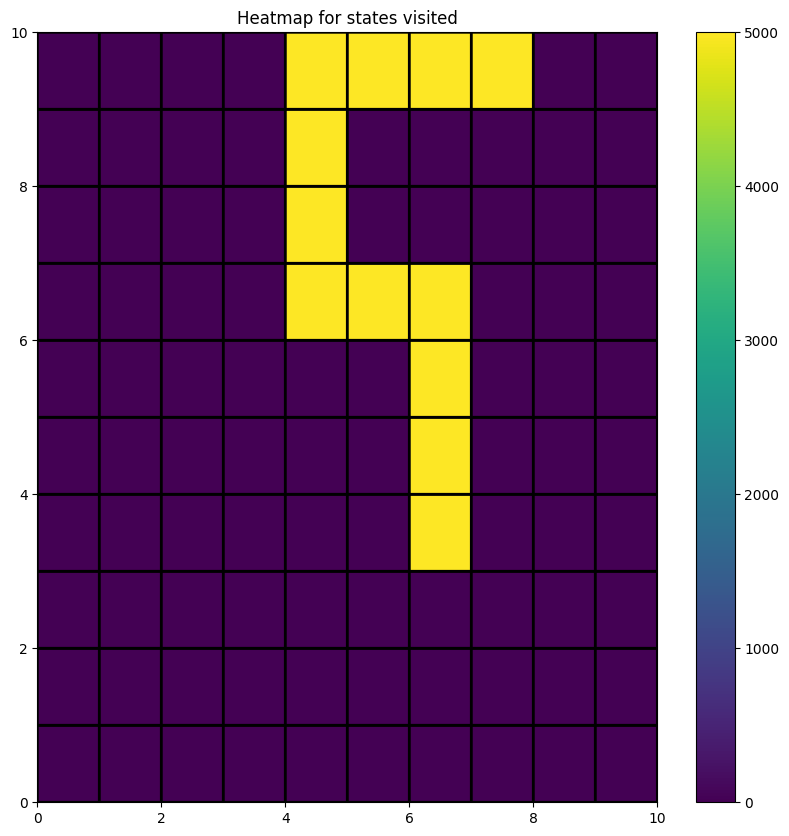

(3, 6) False 0.7
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 761.98it/s]


Best reward:-49.5762
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 712.87it/s]


Best reward:-74.1288
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 645.47it/s]


Best reward:-107.4816
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:27<00:00, 179.75it/s]


Best reward:-72.0218
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 166.14it/s]


Best reward:-79.8344
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:31<00:00, 158.22it/s]


Best reward:-85.936
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 876.78it/s] 


Best reward:-46.5748
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 770.23it/s]


Best reward:-70.7194
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 669.50it/s]


Best reward:-102.2756
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:18<00:00, 267.92it/s]


Best reward:-45.2894
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:24<00:00, 205.74it/s]


Best reward:-61.816
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:28<00:00, 173.63it/s]


Best reward:-77.2378
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 945.23it/s] 


Best reward:-41.2724
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 817.21it/s]


Best reward:-63.0526
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 733.04it/s]


Best reward:-83.7836
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:11<00:00, 435.43it/s]


Best reward:-22.8176
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:13<00:00, 364.53it/s]


Best reward:-30.4322
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:21<00:00, 233.99it/s]


Best reward:-52.141
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 829.60it/s] 


Best reward:-46.9454
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 722.37it/s]


Best reward:-76.0896
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 638.47it/s]


Best reward:-110.7226
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:27<00:00, 184.33it/s]


Best reward:-70.2684
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:30<00:00, 163.73it/s]


Best reward:-80.2412
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:31<00:00, 158.56it/s]


Best reward:-85.9
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 849.25it/s] 


Best reward:-45.9212
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 784.14it/s]


Best reward:-69.277
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:07<00:00, 642.82it/s]


Best reward:-107.1376
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:19<00:00, 261.80it/s]


Best reward:-45.8056
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:23<00:00, 208.96it/s]


Best reward:-60.5008
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:29<00:00, 168.93it/s]


Best reward:-75.744
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 919.92it/s] 


Best reward:-42.6898
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 821.04it/s]


Best reward:-59.5342
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 724.91it/s]


Best reward:-83.4814
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:10<00:00, 470.73it/s]


Best reward:-21.0688
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:13<00:00, 376.25it/s]


Best reward:-28.1234
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:22<00:00, 223.53it/s]


Best reward:-52.3214
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:07<00:00, 632.36it/s]


Best reward:-54.072
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:08<00:00, 583.86it/s]


Best reward:-87.221
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:09<00:00, 535.26it/s]


Best reward:-115.988
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:28<00:00, 173.51it/s]


Best reward:-73.7154
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:29<00:00, 167.96it/s]


Best reward:-79.4594
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:31<00:00, 160.56it/s]


Best reward:-85.9536
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:06<00:00, 782.27it/s]


Best reward:-49.2676
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:07<00:00, 706.74it/s]


Best reward:-72.6988
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:08<00:00, 618.10it/s]


Best reward:-109.7102
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:23<00:00, 217.27it/s]


Best reward:-55.5432
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:24<00:00, 200.68it/s]


Best reward:-62.8842
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:29<00:00, 170.38it/s]


Best reward:-76.1172
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 911.33it/s] 


Best reward:-41.158
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:06<00:00, 804.70it/s]


Best reward:-61.8828
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:06<00:00, 719.83it/s]


Best reward:-87.334
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:12<00:00, 393.29it/s]


Best reward:-24.2646
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:14<00:00, 343.64it/s]


Best reward:-30.0184
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:21<00:00, 236.01it/s]


Best reward:-52.8996
(0.2, 0.9, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:11<00:00, 445.84it/s]


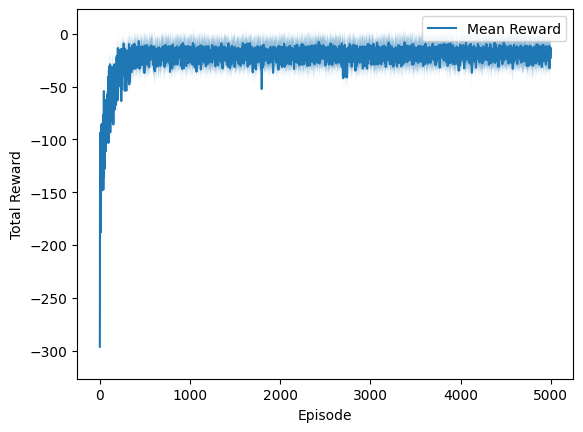

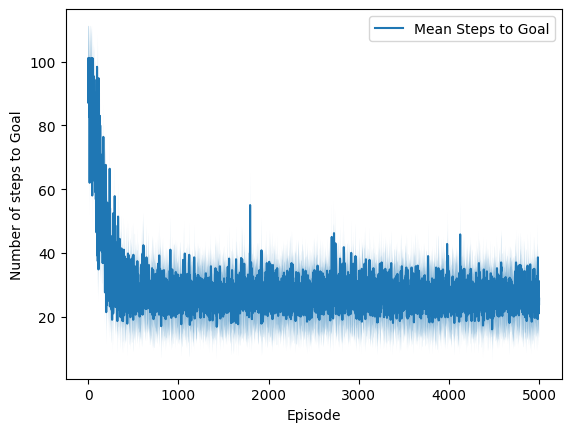

100%|██████████| 5000/5000 [00:08<00:00, 611.17it/s]


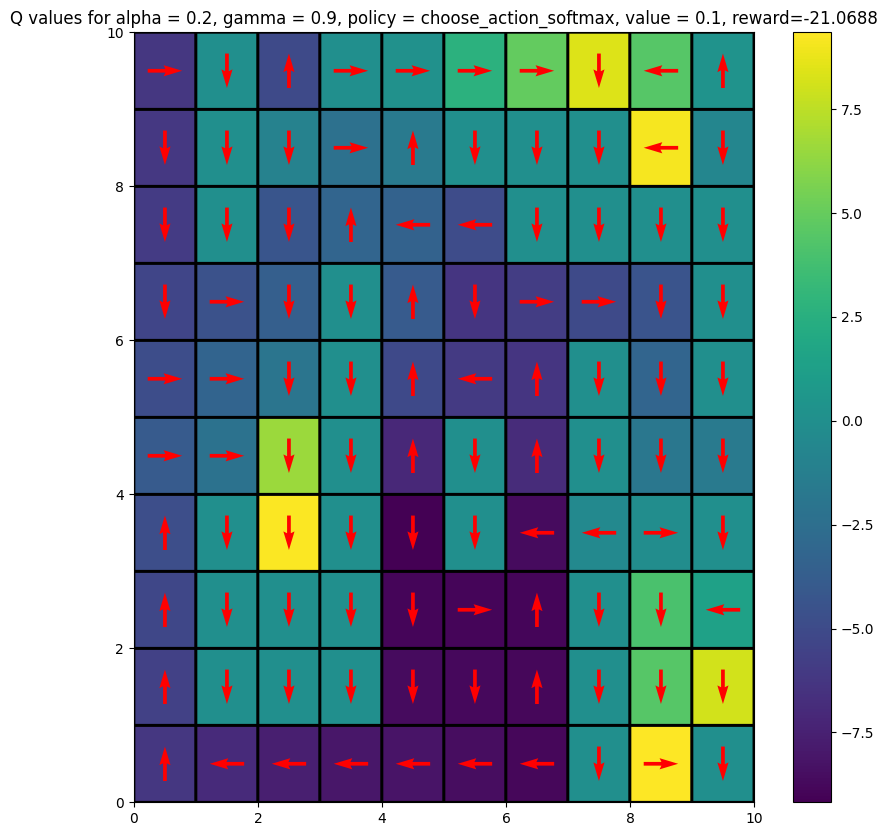

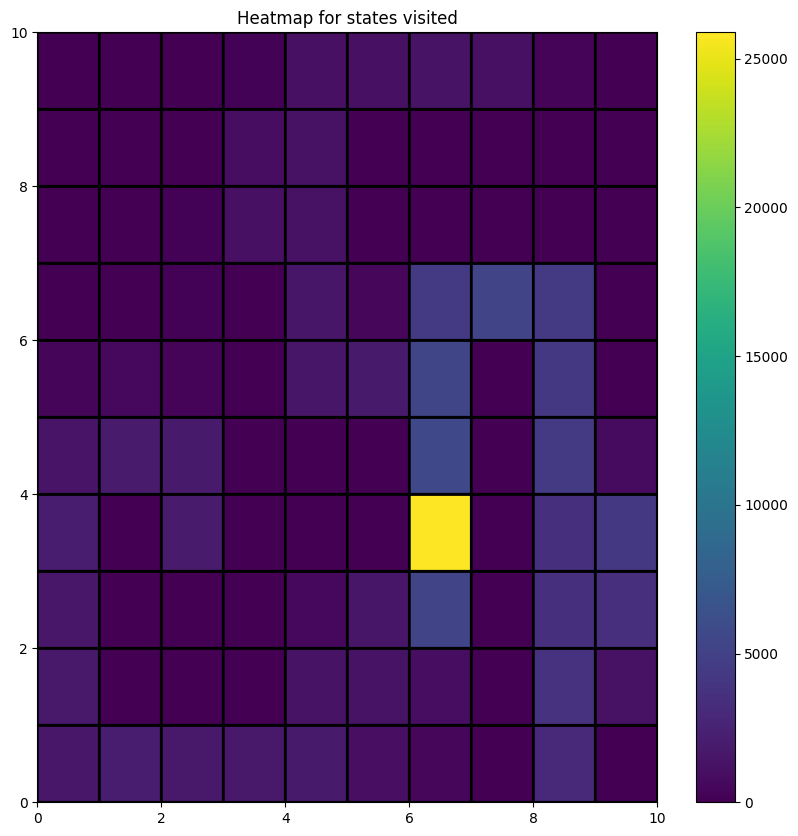

(3, 6) True 1.0
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1720.34it/s]


Best reward:-17.165
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1511.81it/s]


Best reward:-29.4718
0.1 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1264.52it/s]


Best reward:-42.2204
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 553.06it/s]


Best reward:-15.9972
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:17<00:00, 288.08it/s]


Best reward:-39.408
0.1 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 209.83it/s]


Best reward:-56.9194
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1686.93it/s]


Best reward:-15.9982
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1478.62it/s]


Best reward:-27.7864
0.1 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1340.16it/s]


Best reward:-43.4686
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 932.11it/s] 


Best reward:-6.1606
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 699.61it/s]


Best reward:-10.4482
0.1 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 314.40it/s]


Best reward:-35.2458
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1687.15it/s]


Best reward:-15.0284
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1490.25it/s]


Best reward:-27.854
0.1 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1349.57it/s]


Best reward:-40.5098
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 995.04it/s] 


Best reward:-6.4322
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 953.81it/s] 


Best reward:-6.754
0.1 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:08<00:00, 562.34it/s]


Best reward:-14.5348
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1715.25it/s]


Best reward:-15.7608
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1634.92it/s]


Best reward:-26.7104
0.2 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1351.40it/s]


Best reward:-40.83
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:08<00:00, 556.55it/s]


Best reward:-15.562
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:16<00:00, 296.03it/s]


Best reward:-37.9528
0.2 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:24<00:00, 202.45it/s]


Best reward:-57.5012
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1739.93it/s]


Best reward:-13.6126
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1568.58it/s]


Best reward:-26.081
0.2 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1386.09it/s]


Best reward:-40.1788
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 943.29it/s] 


Best reward:-6.1062
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:06<00:00, 745.20it/s]


Best reward:-9.0048
0.2 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 323.57it/s]


Best reward:-32.538
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1841.53it/s]


Best reward:-13.6896
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1712.28it/s]


Best reward:-24.1268
0.2 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1430.09it/s]


Best reward:-40.7884
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1015.38it/s]


Best reward:-5.5162
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 993.02it/s] 


Best reward:-5.08
0.2 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:08<00:00, 610.61it/s]


Best reward:-12.7258
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1775.87it/s]


Best reward:-14.8014
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:02<00:00, 1741.73it/s]


Best reward:-25.547
0.4 0.7 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1481.93it/s]


Best reward:-40.016
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:09<00:00, 534.51it/s]


Best reward:-15.0342
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:17<00:00, 285.11it/s]


Best reward:-41.0186
0.4 0.7 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:23<00:00, 212.75it/s]


Best reward:-55.5462
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1837.02it/s]


Best reward:-13.911
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1604.33it/s]


Best reward:-25.1462
0.4 0.8 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1361.35it/s]


Best reward:-40.5166
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:05<00:00, 895.15it/s] 


Best reward:-4.1442
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:07<00:00, 699.69it/s]


Best reward:-10.9454
0.4 0.8 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:15<00:00, 318.31it/s]


Best reward:-32.7364
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.1


100%|██████████| 5000/5000 [00:02<00:00, 1911.57it/s]


Best reward:-14.096
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.2


100%|██████████| 5000/5000 [00:03<00:00, 1540.61it/s]


Best reward:-25.6344
0.4 0.9 <function choose_action_epsilon at 0x7f7d0f4eb2e0> 0.3


100%|██████████| 5000/5000 [00:03<00:00, 1330.29it/s]


Best reward:-40.7854
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.1


100%|██████████| 5000/5000 [00:04<00:00, 1030.49it/s]


Best reward:-5.3234
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.25


100%|██████████| 5000/5000 [00:05<00:00, 972.64it/s] 


Best reward:-5.7888
0.4 0.9 <function choose_action_softmax at 0x7f7d0f4eb370> 0.75


100%|██████████| 5000/5000 [00:08<00:00, 603.53it/s]


Best reward:-13.3026
(0.4, 0.8, (<function choose_action_softmax at 0x7f7d0f4eb370>, 0.1))


100%|██████████| 5000/5000 [00:05<00:00, 875.18it/s] 


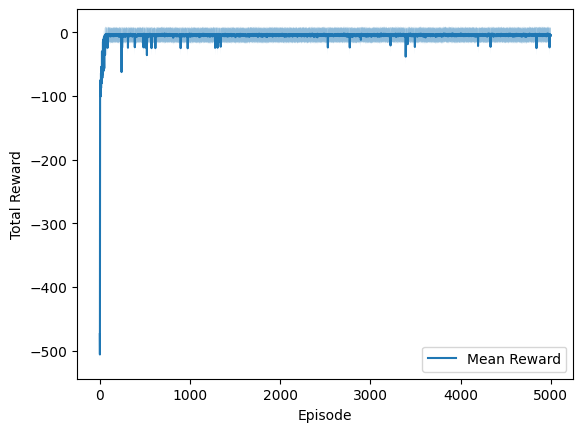

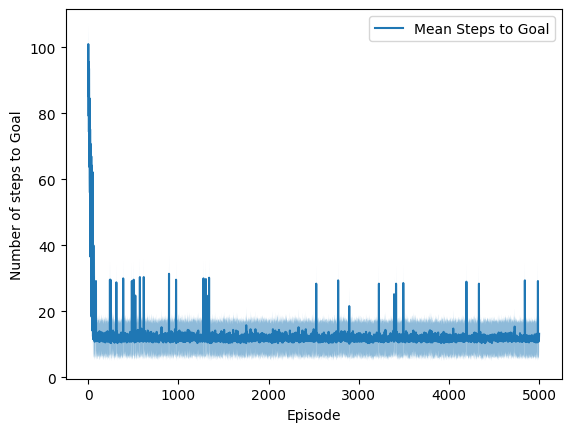

100%|██████████| 5000/5000 [00:04<00:00, 1058.63it/s]


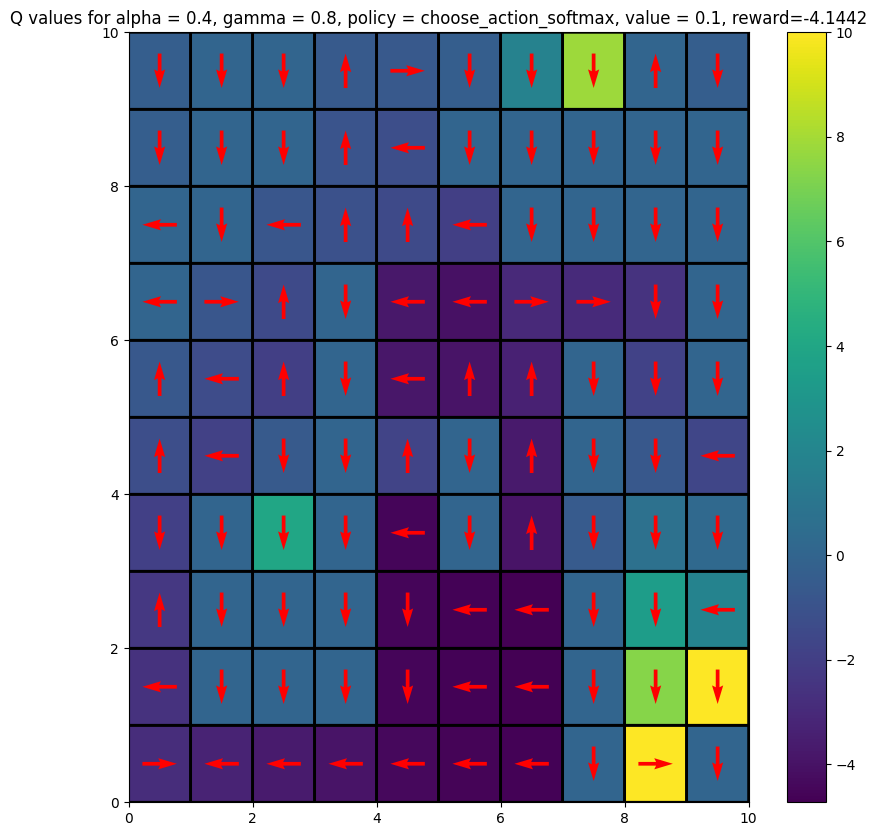

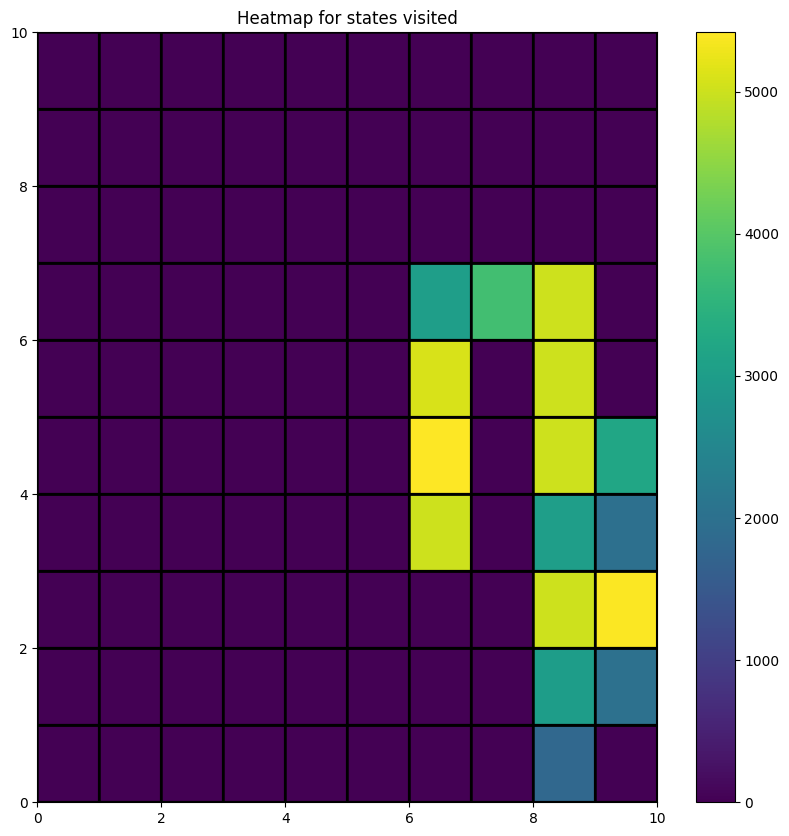

In [23]:
for start, (wind, transition) in init_states:
    print(start, wind, transition)
    env.wind = wind
    env.p_good_trans = transition
    env.start_state = np.array([start])
    # start_state = row_col_to_seq(env.start_state, num_cols)[0]
    # print(start_state)
    env = env.create_gridworld()
    # print(env.goal_states_se)

    episodes = 5000   
    best_reward = -np.inf
    best_params = None

    best_reward_avgs = []
    best_step_avgs = [] 

    
    for a, g, (p, val) in params:
        print(a, g, p, val)
        
        # all_rewards = []
        # all_steps = []    
        Q = np.zeros((num_rows, num_cols, 4))
        # rewards, steps = None, None
        # heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        # for i in range(5):
        #     Q = np.zeros((num_rows, num_cols, 4))
        #     heatmap, rewards, steps = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
        #     all_rewards.append(rewards)
        #     all_steps.append(steps)

        
        heatmap, rewards, steps = Qlearning(Q, env, start, (p, val), a, g, episodes, plot=False)
        # find the best reward
        # avg_reward = (sum(all_rewards)/5)[4000:].mean()
        regret = rewards.mean()
        # show_rewards_steps(all_steps, all_rewards)
        print(f"Best reward:{regret}")
        if best_reward < regret:
            best_reward = regret
            best_params = a, g, (p, val)
            # best_reward_avgs = all_rewards
            # best_step_avgs = all_steps
    
    a, g, (p, val) = best_params

    print(best_params)
    for i in range(5):
        Q = np.zeros((num_rows, num_cols, 4))
        heatmap, rewards, steps = Qlearning(Q, env, start, (p, val), a, g, episodes, plot=False)
        best_reward_avgs.append(rewards)
        best_step_avgs.append(steps)
    show_rewards_steps(best_step_avgs, best_reward_avgs)
    heatmap, _, _ = sarsa(Q, env, start, (p, val), a, g, episodes, plot=False)
    plot_Q(Q, f"Q values for alpha = {a}, gamma = {g}, policy = {p.__name__}, value = {val}, reward={best_reward}")
    plot_heatmap(heatmap, "Heatmap for states visited")
    # sarsa(Q, env, start, (choose_action_epsilon, 0.2), 0.4, 0.999, episodes)